In [ ]:
# Simple Chess Player Types Analysis
# For "Game-based quantification of chess player types" Master Thesis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --------------------------------------------------
# 1. LOAD DATA AND TRANSFORM TO PLAYER-CENTRIC FORMAT
# --------------------------------------------------

# Load the dataset
file_path = '../data/processed/lumbrasgigabase/chess_games_with_features.csv'
chess_df = pd.read_csv(file_path)

print(f"Original dataset shape: {chess_df.shape}")

# Define known player types from the book
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.", "Kasparov, G.",
    "Kasparov, Garry", "Anand, Viswanathan", "Anand,V", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, B.", "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]

theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, M.", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor1", "Moskalenko, Viktor",
    "Moskalenko, V.", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]

reflector_players = [
    "Capablanca, Jose", "Smyslov, V.", "Petrosian, T.", "Karpov, A.",
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K.", "Bischoff,K"
]

pragmatist_players = [
    "Fischer, R.", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]

# Create a dictionary mapping player names to their types
player_type_map = {}
for player in activist_players:
    player_type_map[player] = "Activist"
for player in theorist_players:
    player_type_map[player] = "Theorist"  
for player in reflector_players:
    player_type_map[player] = "Reflector"
for player in pragmatist_players:
    player_type_map[player] = "Pragmatist"

# Identify categorical, identifier, and numerical features
categorical_cols = ['event', 'site', 'date', 'round', 'white', 'black', 'result',
                   'white_title', 'black_title', 'eco', 'opening', 'result_category', 
                   'eco_family', 'opening_name']
identifier_cols = ['white_elo', 'black_elo', 'year']

# Get all columns, then remove categorical and identifier columns to get numerical features
all_cols = chess_df.columns.tolist()
numerical_features = [col for col in all_cols if col not in categorical_cols and col not in identifier_cols]

# Create a dataframe with just the numerical features for analysis
numerical_df = chess_df[numerical_features].copy()

# Handle missing values in numerical features - impute with median
imputer = SimpleImputer(strategy='median')
numerical_df_imputed = pd.DataFrame(imputer.fit_transform(numerical_df), columns=numerical_df.columns)

# Split features into white-specific, black-specific, and common
white_features = [col for col in numerical_features if col.startswith('white_')]
black_features = [col for col in numerical_features if col.startswith('black_')]
common_features = [col for col in numerical_features if not col.startswith('white_') and not col.startswith('black_')]

print(f"\nFeature distribution:")
print(f"White player features: {len(white_features)}")
print(f"Black player features: {len(black_features)}")
print(f"Common game features: {len(common_features)}")

# --------------------------------------------------
# 2. CREATE PLAYER-CENTRIC DATAFRAME
# --------------------------------------------------

# Define phase-specific features where 0 means "phase not played"
phase_specific_features = [
    'white_opening_accuracy', 'white_middlegame_accuracy', 'white_endgame_accuracy',
    'black_opening_accuracy', 'black_middlegame_accuracy', 'black_endgame_accuracy'
]

# Create two new dataframes for players
players_data = []

# Process white players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_color'] = 'white'
    player_data['opponent_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_elo'] = row['white_elo'] if 'white_elo' in chess_df.columns else None
    
    # Add player type if known
    if 'white' in chess_df.columns and row['white'] in player_type_map:
        player_data['player_type'] = player_type_map[row['white']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in white_features:
        feature_name = feature.replace('white_', '')
        value = numerical_df_imputed.iloc[i][feature]
        
        # Handle phase-specific features where 0 means "phase not played"
        if feature in phase_specific_features and value == 0:
            player_data[feature_name] = np.nan  # Mark as missing rather than 0
        else:
            player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df_imputed.iloc[i][feature]
    
    players_data.append(player_data)

# Process black players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_color'] = 'black'
    player_data['opponent_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_elo'] = row['black_elo'] if 'black_elo' in chess_df.columns else None
    
    # Add player type if known
    if 'black' in chess_df.columns and row['black'] in player_type_map:
        player_data['player_type'] = player_type_map[row['black']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in black_features:
        feature_name = feature.replace('black_', '')
        value = numerical_df_imputed.iloc[i][feature]
        
        # Handle phase-specific features where 0 means "phase not played"
        if feature in phase_specific_features and value == 0:
            player_data[feature_name] = np.nan  # Mark as missing rather than 0
        else:
            player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df_imputed.iloc[i][feature]
    
    players_data.append(player_data)

# Convert to dataframe
players_df = pd.DataFrame(players_data)

print(f"\nPlayer-centric dataset shape: {players_df.shape}")
print(f"This represents {chess_df.shape[0]} games × 2 players = {chess_df.shape[0]*2} player instances")

# Count players with known types
known_types_count = players_df['player_type'].notna().sum()
print(f"\nPlayers with known types in dataset: {known_types_count} ({known_types_count/len(players_df)*100:.2f}%)")

# Count by type
if known_types_count > 0:
    type_counts = players_df['player_type'].value_counts()
    print("\nDistribution of known player types:")
    print(type_counts)

# drop forced_complexity_index,speculative_sacrifice_ratio,material_imbalance_tolerance
# columns_to_drop = ['forced_complexity_index', 'speculative_sacrifice_ratio', 'material_imbalance_tolerance']
# columns_to_drop = [col for col in columns_to_drop if col in players_df.columns]
# if columns_to_drop:
#     players_df = players_df.drop(columns=columns_to_drop)
#     print(f"Dropped columns: {columns_to_drop}")
# else:
#     print("Columns to drop not found in DataFrame.")

# Save the player-centric dataframe for future use
players_df.to_csv('player_centric_data.csv', index=False)
print("\nSaved player-centric data to 'player_centric_data.csv'")


Original dataset shape: (4655, 91)

Feature distribution:
White player features: 34
Black player features: 34
Common game features: 6

Player-centric dataset shape: (9310, 47)
This represents 4655 games × 2 players = 9310 player instances

Players with known types in dataset: 5002 (53.73%)

Distribution of known player types:
player_type
Theorist      1814
Activist      1756
Reflector      762
Pragmatist     670
Name: count, dtype: int64
Columns to drop not found in DataFrame.

Saved player-centric data to 'player_centric_data.csv'


In [21]:
# Chess Player Type Analysis - Feature Exploration
# Based on the thesis: "Game-based quantification of chess player types"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set the style for our visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the dataset
df = pd.read_csv('player_centric_data.csv')

# Display basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
display(missing_values[missing_values > 0])

# Basic statistics of numerical features
print("\nBasic Statistics:")
display(df.describe())

# 1. Data Preprocessing

# Define known player types from the book (using the provided mappings)
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.", "Kasparov, G.",
    "Kasparov, Garry", "Anand, Viswanathan", "Anand,V", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, B.", "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]
theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, M.", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor1", "Moskalenko, Viktor",
    "Moskalenko, V.", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]
reflector_players = [
    "Capablanca, Jose", "Smyslov, V.", "Petrosian, T.", "Karpov, A.",
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K.", "Bischoff,K"
]
pragmatist_players = [
    "Fischer, R.", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]

# Function to map players to their types
def assign_player_types():
    """Assign player types based on the known player classifications"""
    # Create a dictionary mapping player names to their types
    player_type_map = {}
    for player in activist_players:
        player_type_map[player] = "Activist"
    for player in theorist_players:
        player_type_map[player] = "Theorist"
    for player in reflector_players:
        player_type_map[player] = "Reflector"
    for player in pragmatist_players:
        player_type_map[player] = "Pragmatist"
    
    # Apply the mapping to the dataframe
    labeled_count = 0
    for player, player_type in player_type_map.items():
        # Use exact match or contains based on your data
        mask = df['player_name'].str.contains(player, case=True, na=False)
        if mask.sum() > 0:
            df.loc[mask, 'player_type'] = player_type
            labeled_count += mask.sum()
            print(f"Labeled {mask.sum()} games for {player} as {player_type}")
    
    print(f"\nTotal labeled games: {labeled_count}")
    print(f"Player type distribution:")
    display(df['player_type'].value_counts())
    
    # Create color-based player type for visualizations
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Reflector': 'green',
        'Pragmatist': 'purple'
    }
    
    df['player_type_color'] = df['player_type'].map(color_map)
    
    return labeled_count

# Apply the function to assign player types
labeled_count = assign_player_types()

# 2. Feature Grouping and Selection

# Group features by category for easier analysis
feature_groups = {
    'Opening Features': ['minor_piece_development', 'queen_development', 'castle_move', 'opening_novelty_score', 'opening_accuracy', 'opening_length'],
    'Material Handling': ['material_changes', 'material_volatility', 'piece_exchange_rate', 'pawn_exchange_rate', 'capture_frequency', 'material_balance_std'],
    'Positional Features': ['piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 'center_control_avg', 'space_advantage'],
    'King Safety': ['king_safety', 'king_safety_min', 'vulnerability_spikes', 'check_frequency'],
    'Move Quality': ['accuracy', 'brilliant_count', 'great_count', 'good_moves', 'inaccuracy_count', 'mistake_count', 'blunder_count', 'top_move_alignment', 'top2_3_move_alignment'],
    'Game Phase': ['middlegame_accuracy', 'endgame_accuracy', 'middlegame_length', 'endgame_length'],
    'Strategic Indicators': ['sacrifice_count', 'prophylactic_frequency', 'sharpness', 'eval_volatility', 'avg_eval_change']
}

# Function to get all numeric features
def get_numeric_features():
    """Return all numeric feature columns"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude non-feature columns
    exclude_cols = ['player_elo', 'game_id', 'result']
    return [col for col in numeric_cols if col not in exclude_cols]

# Function to get a clean dataset with imputed values for analysis
def get_clean_data(df_input=None, features=None):
    """Return a clean dataset with imputed missing values"""
    if df_input is None:
        df_input = df
    
    if features is None:
        features = get_numeric_features()
    
    # Create a copy to avoid modifying the original
    data = df_input[features].copy()
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)
    
    # Convert back to DataFrame
    data_clean = pd.DataFrame(data_imputed, columns=features, index=df_input.index)
    
    return data_clean

Dataset Shape: (9310, 47)

First few rows:


,player_name,player_color,opponent_name,player_elo,player_type,game_id,result,minor_piece_development,queen_development,castle_move,...,blunder_count,top_move_alignment,top2_3_move_alignment,sharpness,total_moves,opening_length,middlegame_length,endgame_length,material_balance_std,opening_novelty_score
0,"Kupreichik, Viktor D",white,"Tal, Mikhail",2540.0,NaN,0,1/2-1/2,0.340000,0.180000,0.220000,...,0.000000,0.700000,0.220000,2.501763,50.0,0.240000,0.320000,0.440000,1.319811,0.583333
1,"Keres, Paul",white,"Tal, Mikhail",NaN,NaN,1,1/2-1/2,0.684211,1.526316,0.421053,...,0.000000,0.315789,0.473684,1.501872,19.0,0.736842,0.263158,0.000000,1.802912,0.214286
2,"Tal, Mikhail",white,"Keene, Raymond D",NaN,Activist,2,0-1,0.400000,0.366667,0.333333,...,0.033333,0.533333,0.133333,2.021509,30.0,0.400000,0.466667,0.133333,1.431590,0.333333
3,"Klovans, Janis",white,"Tal, Mikhail",NaN,NaN,3,0-1,0.375000,0.250000,0.275000,...,0.000000,0.475000,0.200000,8.298026,40.0,0.175000,0.725000,0.100000,1.791187,1.000000
4,"Tal, Mikhail",white,"Benko, Pal",NaN,Activist,4,1-0,0.366667,0.433333,0.266667,...,0.100000,0.433333,0.333333,2.700204,30.0,0.266667,0.733333,0.000000,1.231079,0.375000



Missing Values:


player_elo             1671
player_type            4308
middlegame_accuracy     164
endgame_accuracy       3044
dtype: int64


Basic Statistics:


,player_elo,game_id,minor_piece_development,queen_development,castle_move,material_changes,material_volatility,piece_exchange_rate,pawn_exchange_rate,capture_frequency,...,blunder_count,top_move_alignment,top2_3_move_alignment,sharpness,total_moves,opening_length,middlegame_length,endgame_length,material_balance_std,opening_novelty_score
count,7639.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,...,9310.000000,9310.000000,9310.000000,9310.000000,9310.00000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000
mean,2593.980102,2327.000000,0.430547,0.418041,0.242451,0.104056,0.279053,0.110456,0.097205,0.207661,...,0.007150,0.537248,0.294407,2.716044,39.97594,0.338066,0.426080,0.235854,1.226891,0.392563
std,148.644441,1343.854895,0.320876,0.334073,0.177921,0.028857,0.102270,0.039901,0.036724,0.057486,...,0.017923,0.115746,0.087816,1.411402,16.16769,0.178452,0.180443,0.220130,0.431033,0.211529
min,1528.000000,0.000000,0.063953,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.404038,6.00000,0.040698,0.000000,0.000000,0.000000,0.058824
25%,2505.000000,1163.250000,0.241379,0.214286,0.129032,0.087379,0.216091,0.088235,0.073171,0.175000,...,0.000000,0.461538,0.235294,1.886164,29.00000,0.216667,0.294118,0.000000,0.971589,0.222222
50%,2602.000000,2327.000000,0.333333,0.325000,0.208333,0.104651,0.277108,0.109091,0.096774,0.208333,...,0.000000,0.537474,0.291667,2.343381,39.00000,0.292683,0.423077,0.210526,1.255617,0.363636
75%,2714.000000,3490.750000,0.500000,0.500000,0.323529,0.122222,0.342105,0.134615,0.120000,0.243738,...,0.000000,0.612903,0.346939,3.107883,49.00000,0.407407,0.565217,0.413678,1.457021,0.500000
max,2882.000000,4654.000000,2.666667,2.666667,1.000000,0.212121,0.769231,0.315789,0.333333,0.416667,...,0.382353,1.000000,0.875000,16.896407,172.00000,1.000000,0.885714,0.863354,4.813311,1.000000


Labeled 19 games for Alekhine, Alexander as Activist
Labeled 113 games for Tal, Mikhail as Activist
Labeled 110 games for Spassky, Boris V. as Activist
Labeled 211 games for Kasparov, G. as Activist
Labeled 105 games for Kasparov, Garry as Activist
Labeled 132 games for Anand, Viswanathan as Activist
Labeled 9 games for Anand,V as Activist
Labeled 128 games for Shirov, Alexei as Activist
Labeled 121 games for Morozevich, Alexander as Activist
Labeled 130 games for Topalov, Veselin as Activist
Labeled 4 games for Pillsbury, Harry as Activist
Labeled 3 games for Anderssen, Adolf as Activist
Labeled 113 games for Bronstein, David I as Activist
Labeled 1 games for Bronstein, Luis Marcos as Activist
Labeled 199 games for Larsen, B. as Activist
Labeled 99 games for Larsen, Bent as Activist
Labeled 114 games for Taimanov, Mark E as Activist
Labeled 132 games for Aronian, Levon as Activist
Labeled 116 games for Polgar, Judit as Activist
Labeled 101 games for Muller, K. as Activist
Labeled 31 g

player_type
Theorist      1814
Activist      1756
Reflector      933
Pragmatist     670
Name: count, dtype: int64

Starting exploratory data analysis...


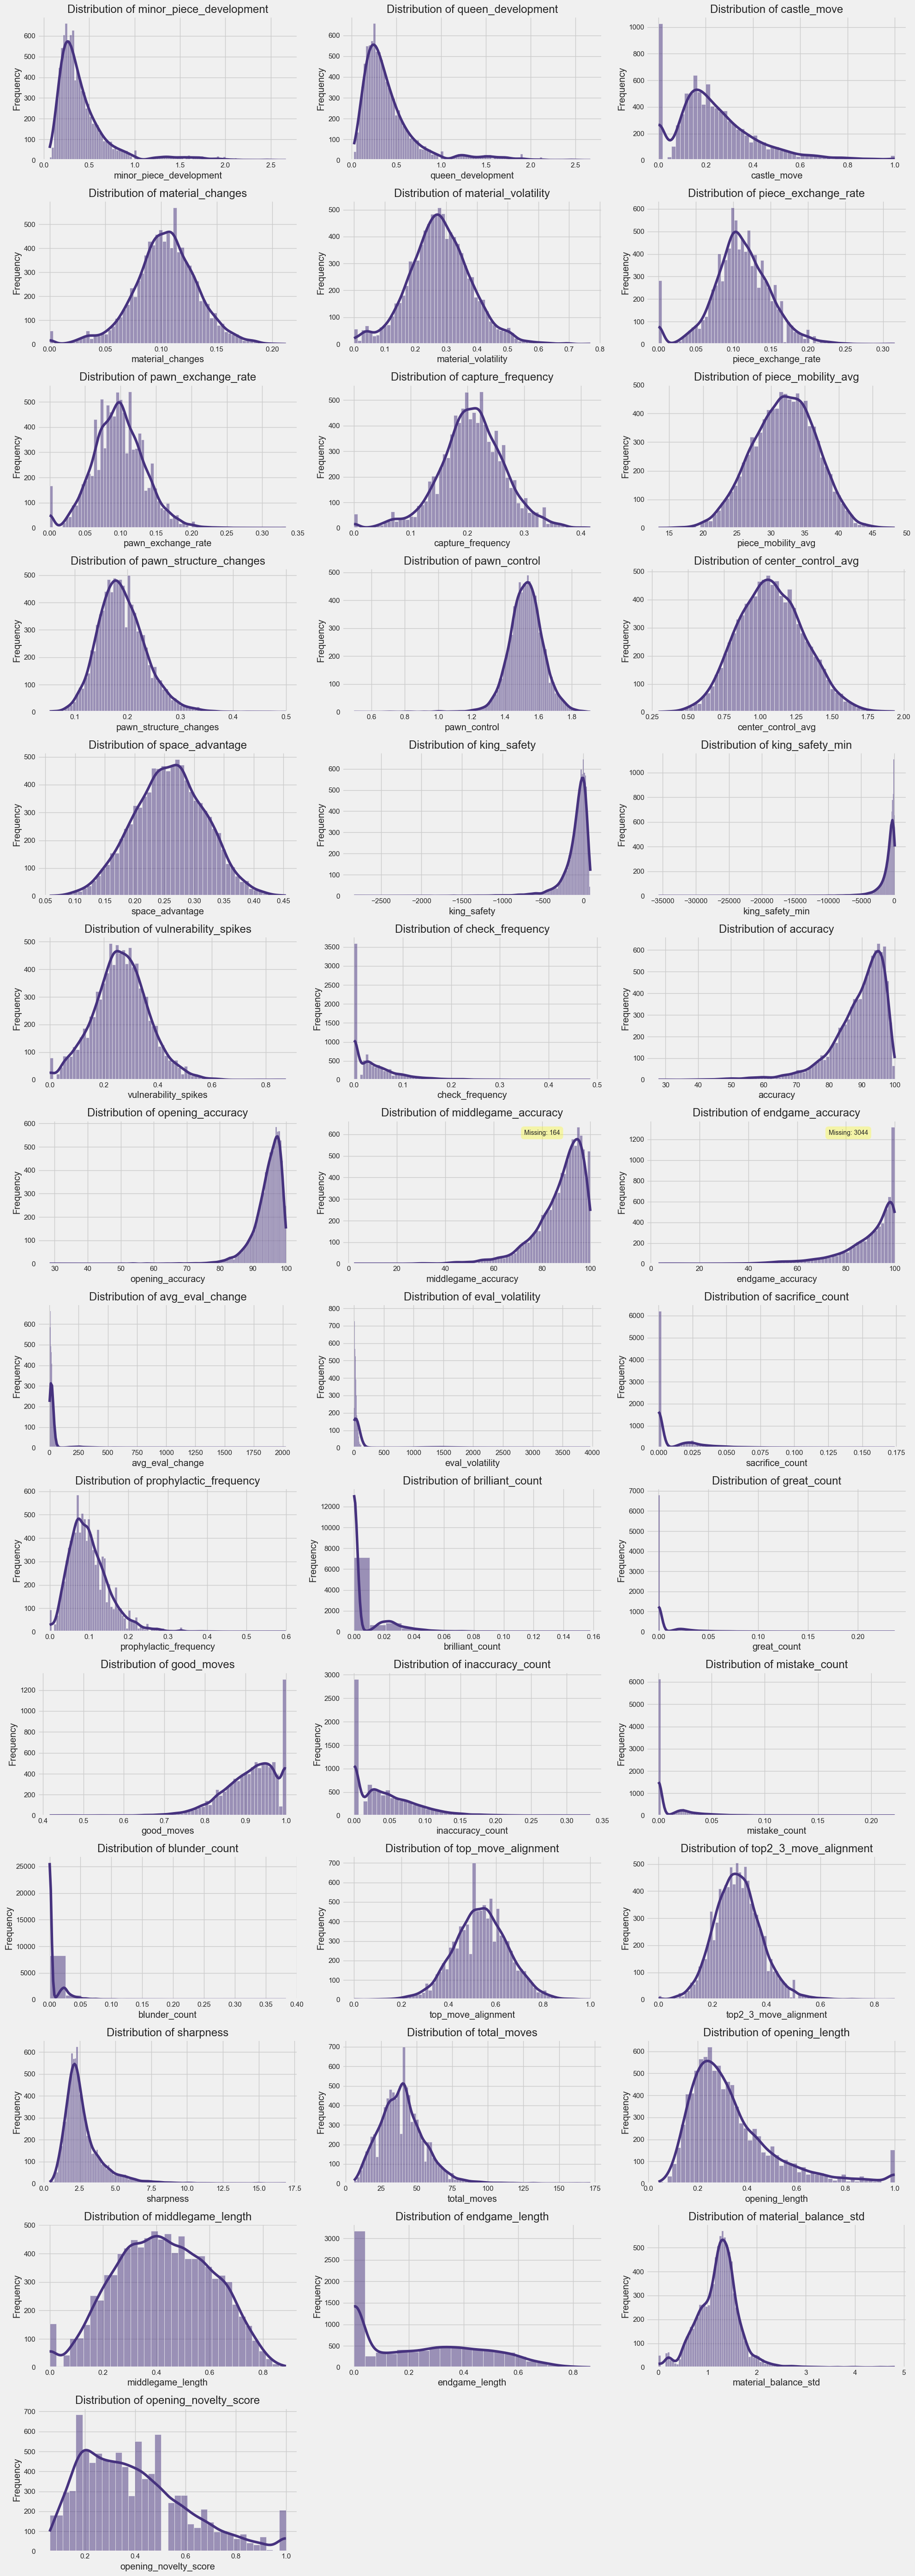

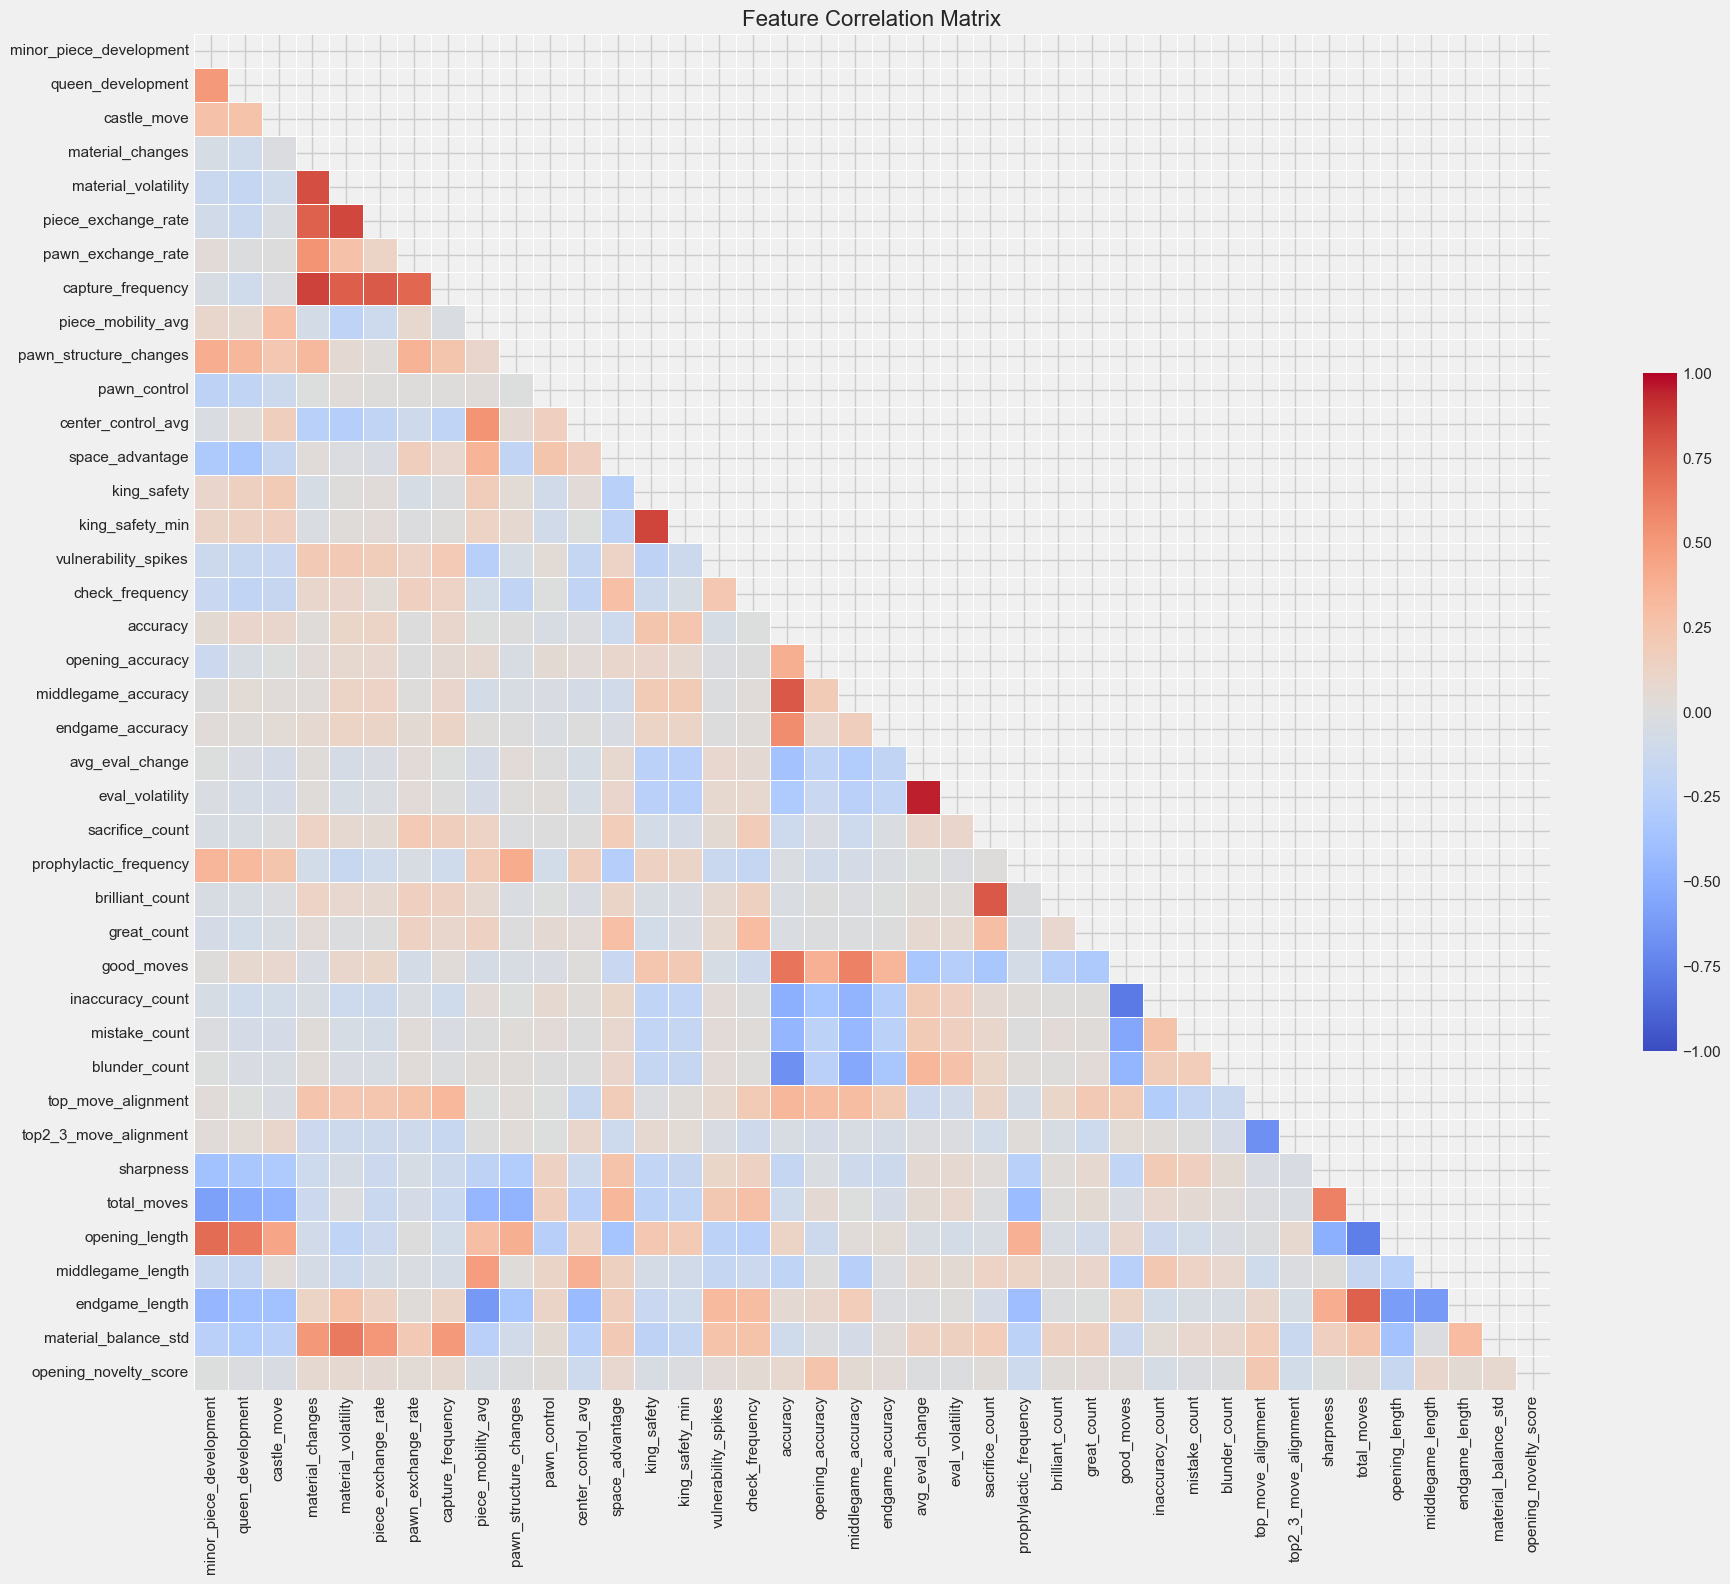


Highly correlated feature pairs (|r| > 0.7):
eval_volatility -- avg_eval_change: 0.9492
capture_frequency -- material_changes: 0.8524
king_safety_min -- king_safety: 0.8454
piece_exchange_rate -- material_volatility: 0.8423
material_volatility -- material_changes: 0.8156
inaccuracy_count -- good_moves: -0.7861
brilliant_count -- sacrifice_count: 0.7803
middlegame_accuracy -- accuracy: 0.7796
capture_frequency -- piece_exchange_rate: 0.7734
opening_length -- total_moves: -0.7583
capture_frequency -- material_volatility: 0.7571
endgame_length -- total_moves: 0.7467
piece_exchange_rate -- material_changes: 0.7449
capture_frequency -- pawn_exchange_rate: 0.7250

Performing Principal Component Analysis...


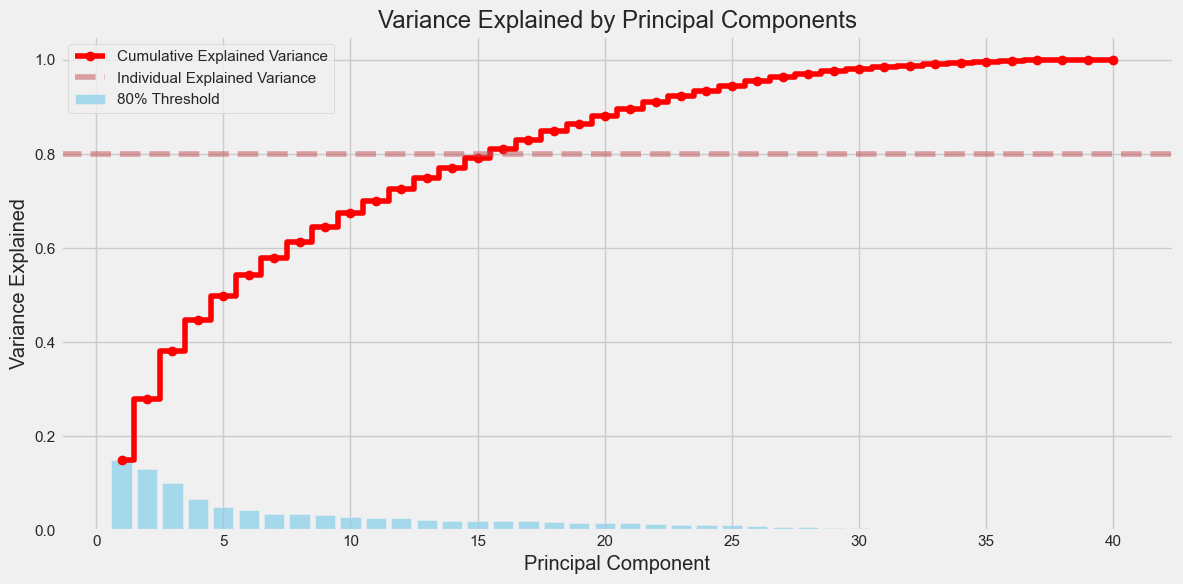


Number of components needed to explain 80% variance: 16


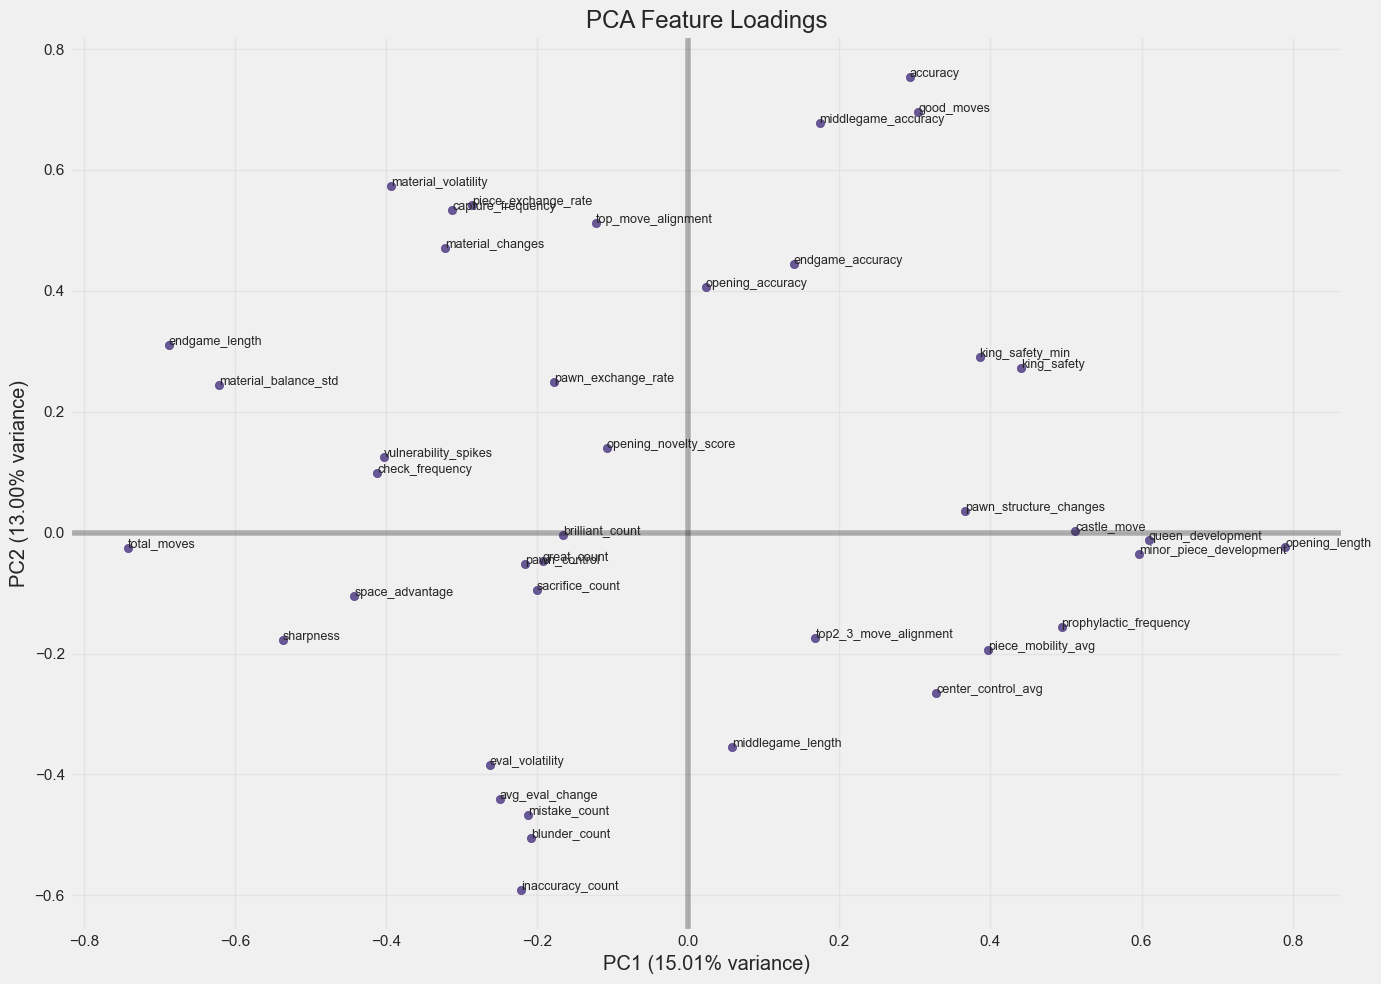

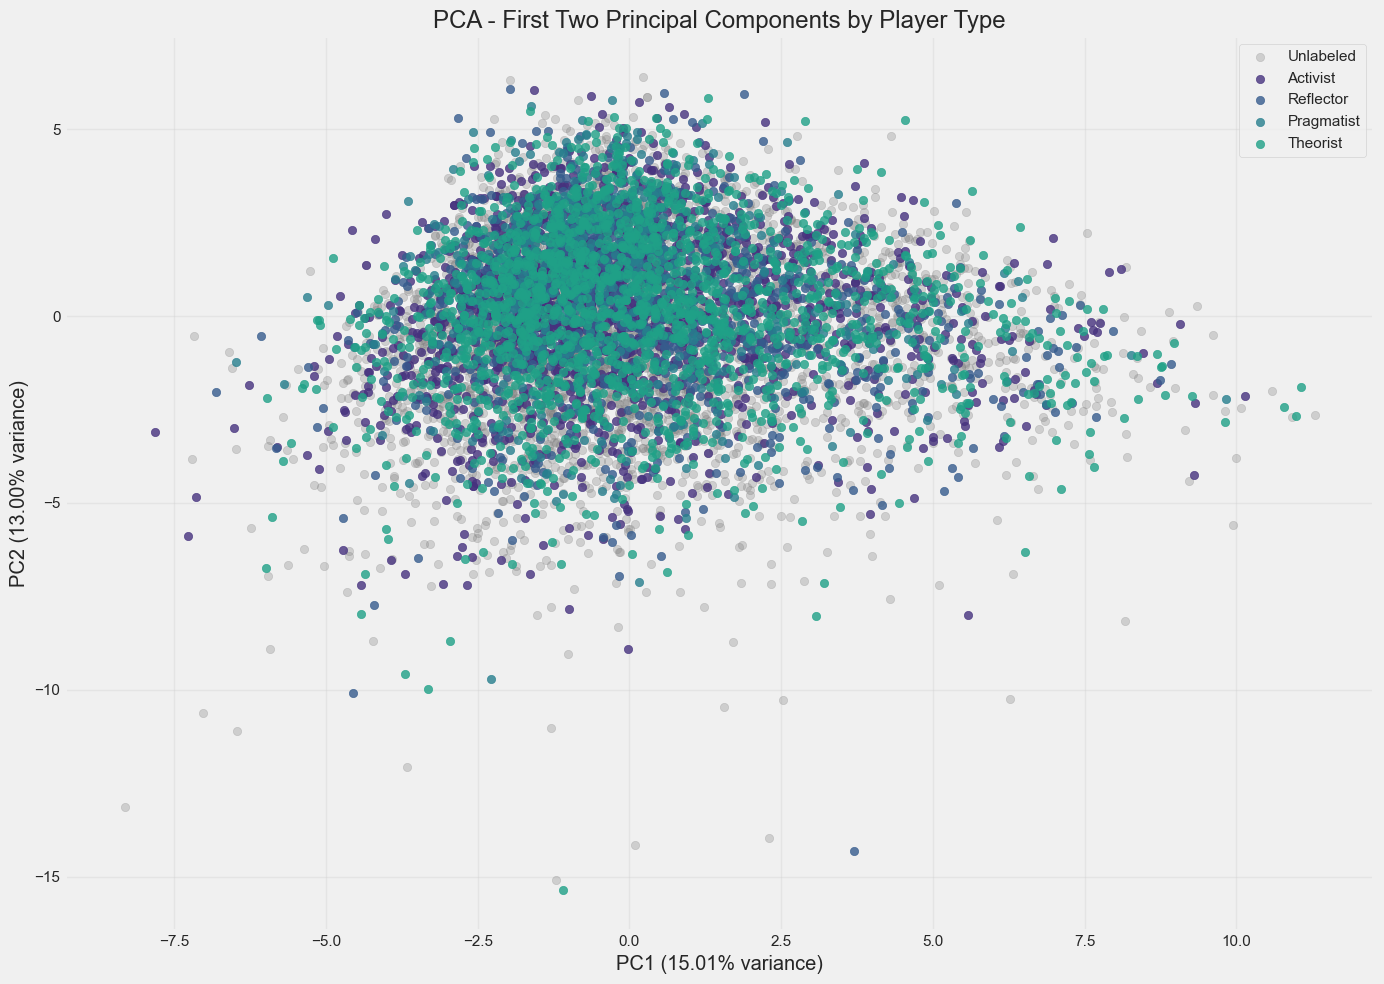


Performing t-SNE visualization...
Starting t-SNE visualization process...
Found 40 numeric features
Sampling 1000 out of 9310 data points
Working with 1000 samples
Found 532 labeled samples
Imputing 352 missing values
Standardizing features...
Skipping PCA (fewer features than requested components)
Running t-SNE with perplexity=30, max_iter=1000...
t-SNE completed in 3.10 seconds


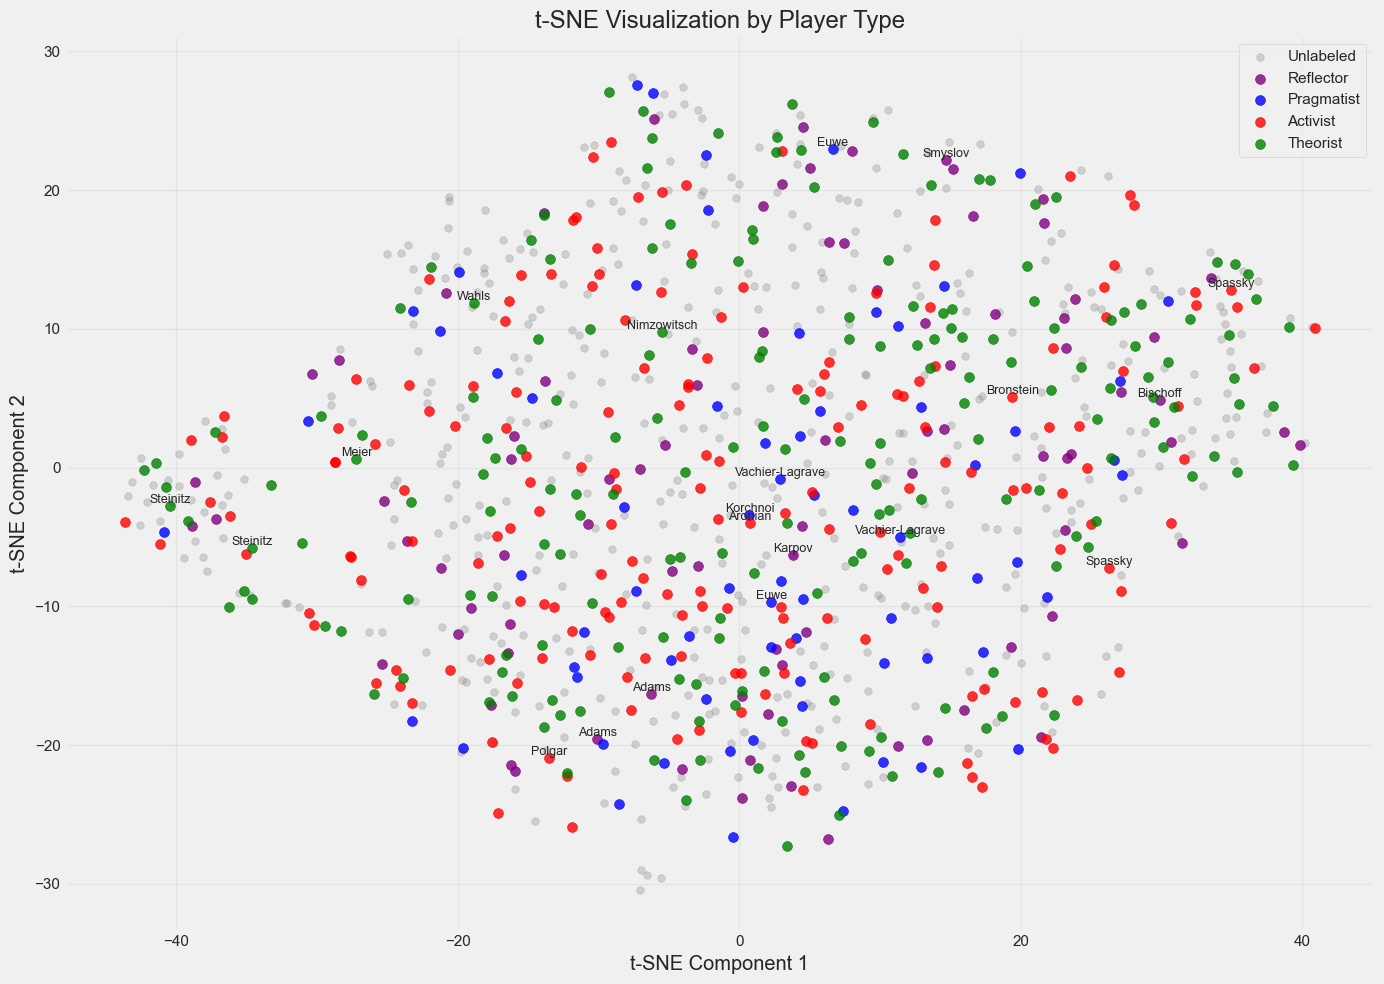


Analyzing features by player type...
Starting feature distribution analysis...
Found 5002 labeled data points

Player type distribution:
  Theorist: 1814 samples
  Activist: 1756 samples
  Reflector: 762 samples
  Pragmatist: 670 samples
Using 4 player types with 20+ samples each: ['Theorist', 'Activist', 'Reflector', 'Pragmatist']

Calculating feature significance...
Found 40 features with sufficient data
Processing feature 1/40...
Processing feature 11/40...
Processing feature 21/40...
Processing feature 31/40...

ANOVA calculations completed in 0.1 seconds

Most significant features differentiating player types:
1. top_move_alignment: p-value = 0.0000 ***
2. opening_accuracy: p-value = 0.0000 ***
3. space_advantage: p-value = 0.0000 ***
4. opening_novelty_score: p-value = 0.0000 ***
5. material_changes: p-value = 0.0000 ***
6. material_volatility: p-value = 0.0000 ***
7. capture_frequency: p-value = 0.0000 ***
8. material_balance_std: p-value = 0.0000 ***
9. piece_exchange_rate: p-

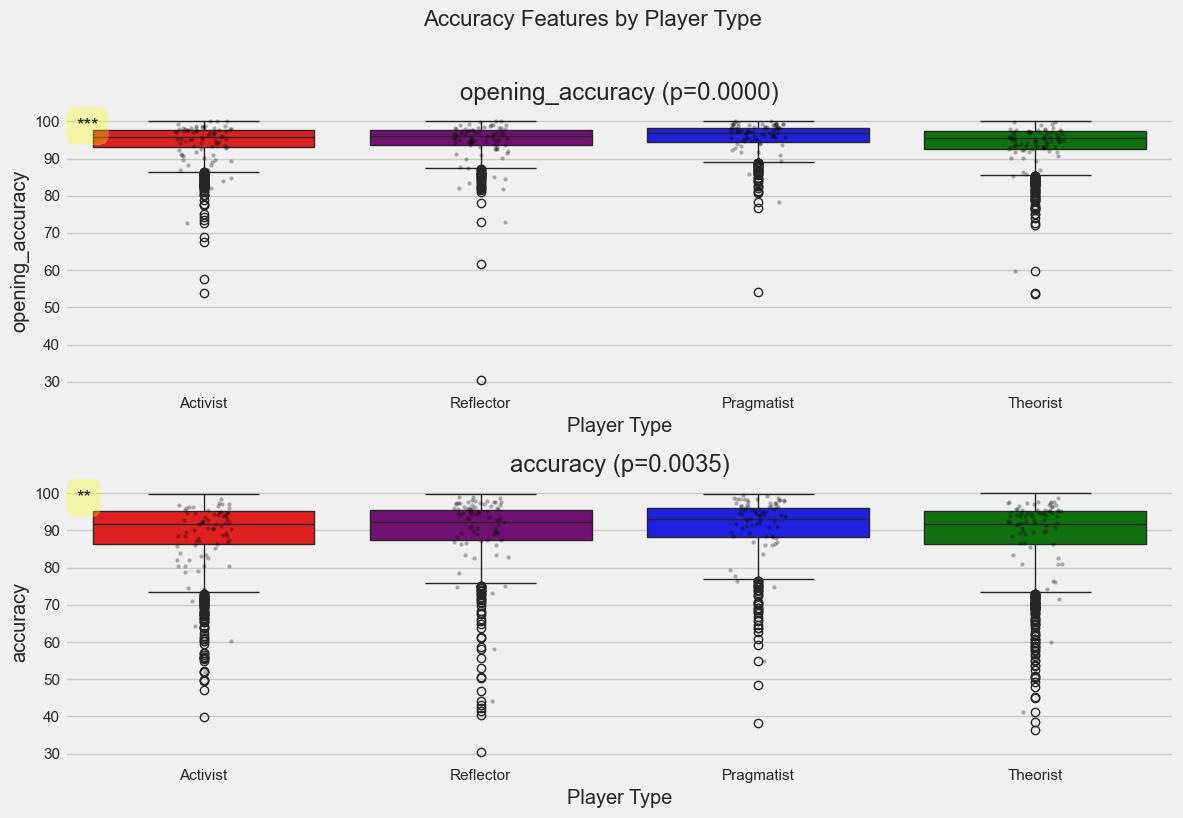

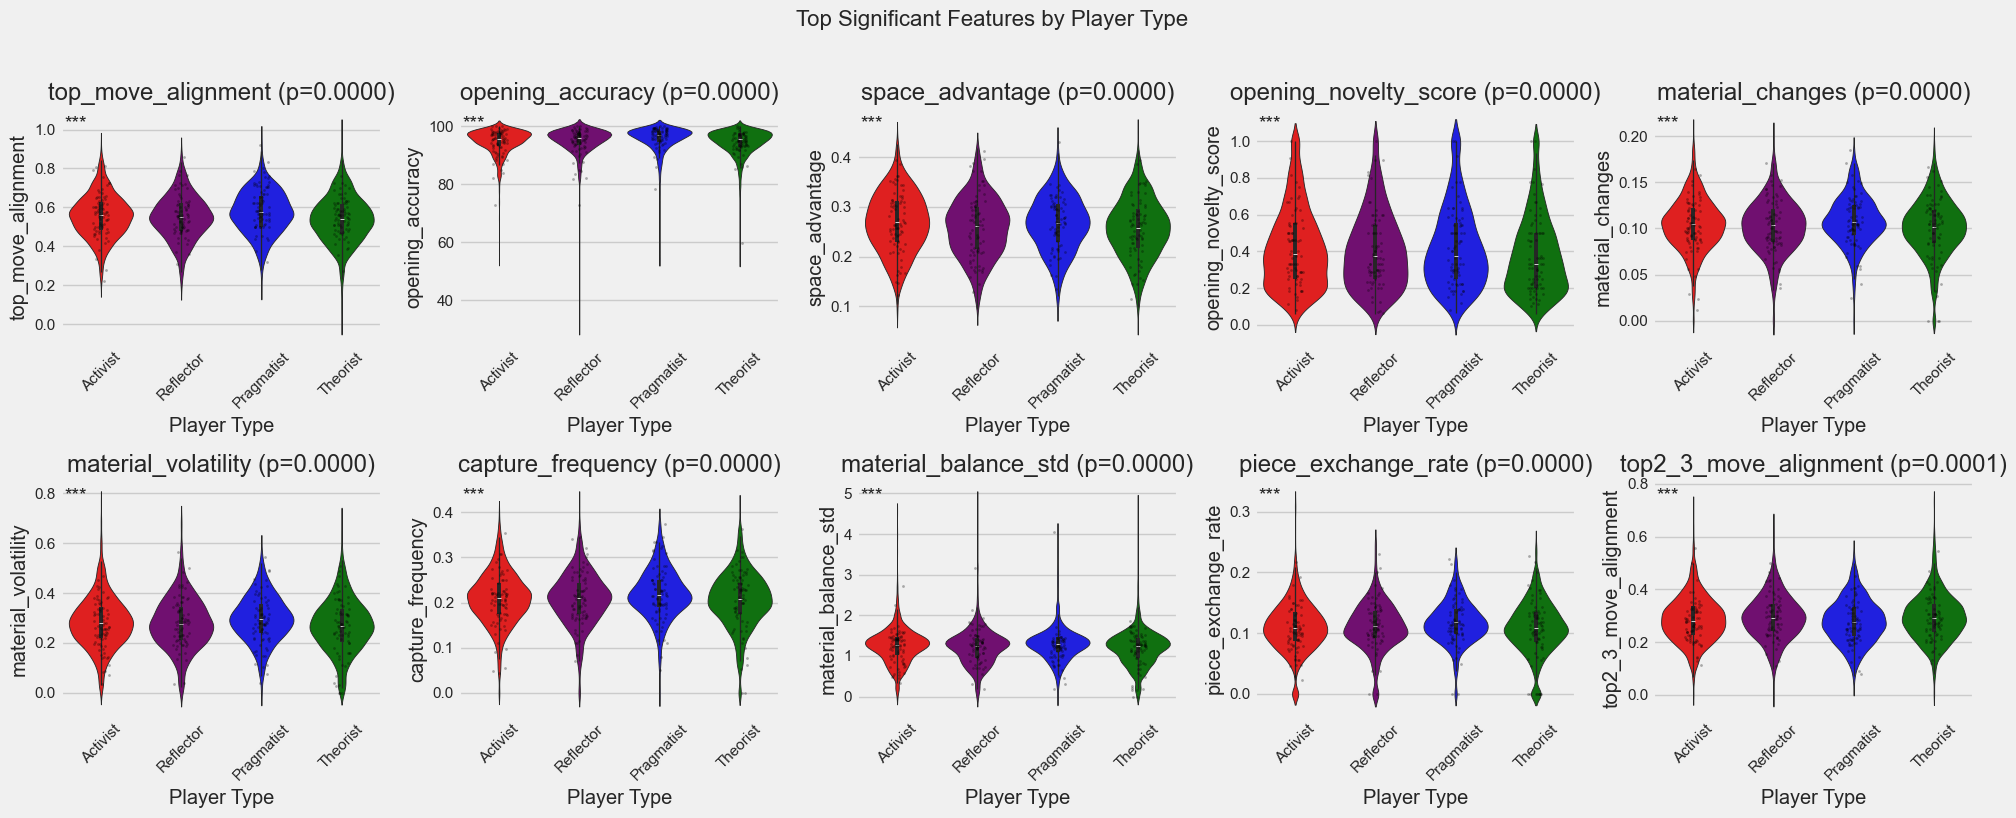


Feature distribution analysis completed in 1.6 seconds
Starting comprehensive player type analysis...

Player type distribution:
  Theorist: 1814 samples
  Activist: 1756 samples
  Reflector: 762 samples
  Pragmatist: 670 samples
Analyzing 40 numeric features across 4 player types
Calculating statistics for all features...

COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON

Development & Initiative:
----------------------------------------------------------------------------------------------------
Feature                        p-value    Theorist   Activist   Reflector  Pragmatist Effect    
----------------------------------------------------------------------------------------------------
castle_move **                 0.0086     0.250      0.231      0.239      0.234      8.3%      
minor_piece_development *      0.0118     0.438      0.424      0.400      0.405      9.5%      
queen_development *            0.0166     0.432      0.416      0.419      0.385      12.3%     
check_frequ

In [22]:
# 3. Exploratory Data Analysis

# 3.1 Distribution Analysis for all numeric features
def plot_feature_distributions():
    """Plot histograms for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Calculate number of rows and columns for subplots
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            sns.histplot(df[feature].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            
            # Add missing value count if any
            na_count = df[feature].isna().sum()
            if na_count > 0:
                axes[i].annotate(f'Missing: {na_count}', xy=(0.7, 0.9), xycoords='axes fraction',
                              fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_features_by_player_type(df, feature_groups=None, max_features_per_group=3, 
                                max_groups=2, min_samples=10, alpha=0.01,
                                use_swarmplot=False, sample_size=400, dpi=100,
                                skip_plots=False):
    """
    Plot feature distributions grouped by player type - high performance version
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    feature_groups : dict, optional
        Dictionary of feature groups to plot. If None, will use predefined groups.
    max_features_per_group : int, default=3
        Maximum features to plot per group
    max_groups : int, default=2
        Maximum number of feature groups to plot
    min_samples : int, default=10
        Minimum samples required per player type to include feature
    alpha : float, default=0.01
        Significance threshold for ANOVA tests
    use_swarmplot : bool, default=False
        Whether to use swarmplot (slow) or stripplot (fast)
    sample_size : int, default=400
        Maximum number of points to plot per chart (for speed)
    dpi : int, default=100
        Resolution for saved images
    skip_plots : bool, default=False
        If True, only calculates significant features without plotting
    
    Returns:
    --------
    dict : Dictionary of feature p-values
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting feature distribution analysis...")
    
    # Count labeled data points
    labeled_count = df['player_type'].notna().sum()
    
    if labeled_count == 0:
        print("No labeled data found. Cannot create player type distributions.")
        return {}
        
    print(f"Found {labeled_count} labeled data points")
    
    # Create a dataframe of only labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Skip types with too few samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each. Analysis stopped.")
        return {}
    
    print(f"Using {len(valid_types)} player types with {min_samples}+ samples each: {valid_types}")
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns 
                      if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    # Define feature groups if not provided
    if feature_groups is None:
        feature_groups = {
            'Accuracy Features': [f for f in numeric_features if 'accuracy' in f],
            'Tactical Features': [f for f in numeric_features if any(x in f for x in 
                                 ['sacrifice', 'brilliant', 'blunder', 'mistake', 'sharpness'])],
            'Positional Features': [f for f in numeric_features if any(x in f for x in 
                                  ['prophylactic', 'mobility', 'center_control', 'king_safety'])],
            'Strategic Features': [f for f in numeric_features if any(x in f for x in
                                 ['space_advantage', 'pawn_control', 'material_balance'])]
        }
    
    # Limit to max_groups
    feature_groups = dict(list(feature_groups.items())[:max_groups])
    
    # Find significant features
    print("\nCalculating feature significance...")
    start_calc_time = time.time()
    all_p_values = {}
    
    # Calculate data availability for each feature
    feature_availability = {}
    for feature in numeric_features:
        # Count non-missing values per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        # Only include feature if all player types have sufficient samples
        if (availability >= min_samples).all():
            feature_availability[feature] = availability.min()
    
    print(f"Found {len(feature_availability)} features with sufficient data")
    
    # Calculate ANOVA p-values for features with sufficient data
    total_features = len(feature_availability)
    for i, (feature, min_avail) in enumerate(feature_availability.items()):
        # Progress reporting for long calculations
        if i % 10 == 0:
            print(f"Processing feature {i+1}/{total_features}...")
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print most significant features
    print(f"\nANOVA calculations completed in {time.time() - start_calc_time:.1f} seconds")
    print("\nMost significant features differentiating player types:")
    for i, (feature, p_val) in enumerate(sorted_features[:10]):
        significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
    
    # Skip plotting if requested
    if skip_plots:
        print("Skipping plots as requested.")
        print(f"Analysis completed in {time.time() - start_time:.1f} seconds")
        return dict(sorted_features)
    
    # Plot feature distributions for each group
    print("\nCreating distribution plots...")
    for group_name, features in feature_groups.items():
        # Filter to features that exist in the dataset and have p-values
        valid_features = [f for f in features if f in all_p_values]
        
        if not valid_features:
            print(f"No valid features in group: {group_name}")
            continue
            
        # Sort by significance and take top N
        sorted_features_group = sorted([(f, all_p_values[f]) for f in valid_features], 
                                key=lambda x: x[1])
        top_features = [f[0] for f in sorted_features_group[:max_features_per_group]]
        
        print(f"\nPlotting {len(top_features)} features from group: {group_name}")
        
        # Create the plot
        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))
        if len(top_features) == 1:
            axes = [axes]
        
        plt.suptitle(f"{group_name} by Player Type", fontsize=16, y=1.02)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Create a custom palette based on player types
        palette = {pt: type_colors.get(pt, 'orange') for pt in valid_types}
        
        for i, feature in enumerate(top_features):
            # Get clean data (drop NaN for this visualization)
            feature_data = labeled_df[['player_type', feature]].dropna()
            
            # Box plot with custom palette
            sns.boxplot(x='player_type', y=feature, data=feature_data, 
                      palette=palette, ax=axes[i])
            
            # PERFORMANCE OPTIMIZATION: Sample data for individual points
            if use_swarmplot:
                # Use swarmplot (slow but accurate positioning)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.swarmplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, ax=axes[i])
            else:
                # Use stripplot (much faster, with jitter)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.stripplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, jitter=True, ax=axes[i])
            
            axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
            axes[i].set_xlabel('Player Type')
            axes[i].set_ylabel(feature)
            
            # Add significance markers
            p_val = all_p_values[feature]
            if p_val < alpha:
                sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                axes[i].annotate(sig_marker, xy=(0.01, 0.97), xycoords='axes fraction',
                              fontsize=14, ha='left', va='top',
                              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig(f'feature_distribution_{group_name.replace(" ", "_")}.png', dpi=dpi)
        plt.show()
    
    # Create a single plot of the top significant features overall
    top_significant = [f for f, p in sorted_features[:min(10, len(sorted_features))]]
    
    if top_significant:
        # Use a 2x5 grid or smaller depending on data
        rows = min(2, (len(top_significant) + 4) // 5)  # Ceiling division, max 2 rows
        cols = min(5, len(top_significant))
        
        # Don't create more subplots than features
        if rows * cols > len(top_significant):
            if len(top_significant) <= 5:
                rows = 1
                cols = len(top_significant)
            else:
                rows = 2
                cols = (len(top_significant) + 1) // 2  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if rows == 1 and cols == 1:
            axes = np.array([axes])  # Make sure it's an array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        plt.suptitle('Top Significant Features by Player Type', fontsize=16, y=1.02)
        
        for i, feature in enumerate(top_significant):
            if i < len(axes):
                # Get clean data for this feature
                feature_data = labeled_df[['player_type', feature]].dropna()
                
                if not feature_data.empty:
                    # Create violin plot
                    sns.violinplot(x='player_type', y=feature, data=feature_data, 
                                 palette=palette, ax=axes[i])
                    
                    # PERFORMANCE OPTIMIZATION: Sample data for individual points
                    if len(feature_data) > sample_size:
                        plot_sample = feature_data.groupby('player_type').apply(
                            lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                              random_state=42)
                        ).reset_index(drop=True)
                    else:
                        plot_sample = feature_data
                    
                    # Add individual data points as stripplot (faster than swarmplot)
                    sns.stripplot(x='player_type', y=feature, data=plot_sample,
                                color='black', alpha=0.3, size=2, ax=axes[i], jitter=True)
                    
                    axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
                    axes[i].set_xlabel('Player Type')
                    axes[i].set_ylabel(feature)
                    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
                    
                    # Add significance markers
                    p_val = all_p_values[feature]
                    if p_val < alpha:
                        sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                        axes[i].annotate(sig_marker, xy=(0.01,.97), xycoords='axes fraction',
                                      fontsize=14, ha='left', va='top')
                else:
                    axes[i].text(0.5, 0.5, f'No data available for {feature}', 
                               ha='center', va='center', fontsize=12)
        
        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('top_significant_features.png', dpi=dpi)
        plt.show()
    
    print(f"\nFeature distribution analysis completed in {time.time() - start_time:.1f} seconds")
    
    # Return the p-values dictionary for potential further analysis
    return dict(sorted_features)

def find_most_significant_features(df, n=10, min_samples=5):
    """
    Find the most significant features that differentiate player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    n : int, default=10
        Number of features to return
    min_samples : int, default=5
        Minimum samples required per player type
    
    Returns:
    --------
    list : Top significant features
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print(f"Finding the {n} most significant features...")
    
    # Check for labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found.")
        return []
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each.")
        return []
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols]
    
    # Calculate p-value for each feature using ANOVA
    significant_features = []
    p_values = []
    
    for feature in numeric_features:
        # Skip if feature has too many missing values
        if labeled_df[feature].isna().sum() > len(labeled_df) * 0.25:
            continue
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Skip if any player type has too few samples
        type_samples = feature_data.groupby('player_type').size()
        if (type_samples < min_samples).any():
            continue
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            significant_features.append(feature)
            p_values.append(p_val)
        except:
            # Skip if ANOVA fails
            continue
    
    # Select top N significant features
    if significant_features:
        # Sort by p-value (ascending)
        sorted_indices = np.argsort(p_values)
        top_features = [significant_features[i] for i in sorted_indices[:n]]
        
        print("\nMost significant features differentiating player types:")
        for i, (feature, p_val) in enumerate(zip([significant_features[i] for i in sorted_indices[:n]], 
                                              [p_values[i] for i in sorted_indices[:n]])):
            significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
        
        print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
        return top_features
    
    print("No significant features found.")
    return []


# 3.3 Correlation Analysis
def plot_correlation_matrix():
    """Plot correlation matrix for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Calculate correlation matrix
    corr_matrix = clean_data.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 16))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=False, fmt='.2f', cbar_kws={"shrink": .5})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # List of highly correlated feature pairs (|r| > 0.7)
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|r| > 0.7):")
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feat1} -- {feat2}: {corr:.4f}")

# 3.4 Principal Component Analysis
def perform_pca():
    """Perform PCA on the features and visualize results"""
    # Get numeric features
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(data=pca_result[:, :2], columns=['PC1', 'PC2'])
    
    # Add player type and name information
    pca_df['player_name'] = df['player_name']
    pca_df['player_type'] = df['player_type']
    pca_df['player_color'] = df['player_color']
    
    # Calculate variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot variance explained
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by Principal Components')
    plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance', '80% Threshold'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Determine number of components needed to explain 80% variance
    n_components = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"\nNumber of components needed to explain 80% variance: {n_components}")
    
    # Plot feature loadings for the first two PCs
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    plt.figure(figsize=(14, 10))
    plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.8)
    
    # Add feature names as annotations
    for i, feature in enumerate(numeric_features):
        plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), fontsize=9)
    
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('PCA Feature Loadings')
    plt.tight_layout()
    plt.show()
    
    # Plot PCA colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = pca_df[pca_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['PC1'], unlabeled['PC2'], alpha=0.3, c='grey', label='Unlabeled')
        
        # Plot labeled data colored by player type
        for pt in df['player_type'].dropna().unique():
            subset = pca_df[pca_df['player_type'] == pt]
            plt.scatter(subset['PC1'], subset['PC2'], alpha=0.8, label=pt)
        
        plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
        plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
        plt.title('PCA - First Two Principal Components by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Return PCA results and components for later use
    return pca, pca_result, numeric_features

# 3.5 t-SNE Visualization
def plot_tsne(df, max_samples=1000, pca_components=50, perplexity=30, n_iter=1000):
    """
    Perform t-SNE on the features and visualize results with optimizations
    for speed and efficiency.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    max_samples : int, default=1000
        Maximum number of samples to use for t-SNE (random sample if more)
    pca_components : int, default=50
        Number of PCA components to use before t-SNE (dimensionality reduction)
    perplexity : int, default=30
        t-SNE perplexity parameter
    n_iter : int, default=1000
        Maximum number of iterations for t-SNE
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import time
    try:
        import plotly.express as px
    except ImportError:
        print("Plotly not available, skipping interactive plot")
    
    print("Starting t-SNE visualization process...")
    start_time = time.time()
    
    # Get numeric features (excluding metadata columns)
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Found {len(numeric_features)} numeric features")
    
    # Sample the data if it's too large
    if len(df) > max_samples:
        print(f"Sampling {max_samples} out of {len(df)} data points")
        df_sample = df.sample(max_samples, random_state=42)
    else:
        df_sample = df.copy()
    
    print(f"Working with {len(df_sample)} samples")
    
    # Count labeled samples
    labeled_count = df_sample['player_type'].notna().sum()
    print(f"Found {labeled_count} labeled samples")
    
    # Get clean data with imputed values
    # First check if there are missing values
    missing_data = df_sample[numeric_features].isna().sum().sum()
    if missing_data > 0:
        print(f"Imputing {missing_data} missing values")
        # Simple imputation with median
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        clean_data = pd.DataFrame(
            imputer.fit_transform(df_sample[numeric_features]),
            columns=numeric_features
        )
    else:
        clean_data = df_sample[numeric_features].copy()
    
    # Standardize the data
    print("Standardizing features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Use PCA for initial dimensionality reduction
    if len(numeric_features) > pca_components:
        print(f"Reducing dimensions from {len(numeric_features)} to {pca_components} with PCA")
        pca = PCA(n_components=pca_components)
        pca_result = pca.fit_transform(scaled_features)
        tsne_input = pca_result
        variance_explained = np.sum(pca.explained_variance_ratio_)
        print(f"Variance explained by {pca_components} components: {variance_explained:.2%}")
    else:
        print("Skipping PCA (fewer features than requested components)")
        tsne_input = scaled_features
    
    # Adjust perplexity if needed
    actual_perplexity = min(perplexity, len(df_sample) - 1)
    if actual_perplexity != perplexity:
        print(f"Adjusting perplexity from {perplexity} to {actual_perplexity} due to sample size")
    
    # Perform t-SNE with early stopping
    print(f"Running t-SNE with perplexity={actual_perplexity}, max_iter={n_iter}...")
    tsne = TSNE(
        n_components=2,
        perplexity=actual_perplexity,
        n_iter=n_iter,
        n_iter_without_progress=100,  # Stop early if no progress
        random_state=42
    )
    
    tsne_result = tsne.fit_transform(tsne_input)
    print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")
    
    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df['player_name'] = df_sample['player_name'].values
    tsne_df['player_type'] = df_sample['player_type'].values
    tsne_df['player_color'] = df_sample['player_color'].values
    
    # Plot t-SNE colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = tsne_df[tsne_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['TSNE1'], unlabeled['TSNE2'], 
                       alpha=0.3, c='grey', label='Unlabeled', s=30)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Plot labeled data colored by player type
        for pt in df_sample['player_type'].dropna().unique():
            subset = tsne_df[tsne_df['player_type'] == pt]
            plt.scatter(
                subset['TSNE1'], 
                subset['TSNE2'], 
                alpha=0.8, 
                label=pt,
                c=type_colors.get(pt, 'orange'),
                s=50
            )
            
            # Add labels for famous players (optional)
            famous_players = subset.head(5)  # Label first 5 of each type
            for _, player in famous_players.iterrows():
                plt.text(
                    player['TSNE1'], 
                    player['TSNE2'], 
                    player['player_name'].split(',')[0],  # First part of name
                    fontsize=9,
                    ha='center',
                    va='bottom'
                )
        
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title('t-SNE Visualization by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('tsne_player_types.png', dpi=300)
        plt.show()
    
        # Create interactive Plotly version (if available)
        try:
            fig = px.scatter(
                tsne_df,
                x='TSNE1',
                y='TSNE2',
                color='player_type',
                hover_name='player_name',
                color_discrete_map=type_colors,
                title='t-SNE Visualization of Chess Player Types',
                opacity=0.8
            )
            fig.update_layout(width=1000, height=800)
            fig.show()
        except:
            print("Skipping interactive plot due to error")
    
    return tsne_result

def comprehensive_player_type_analysis(df, exclude_cols=None, min_samples=20):
    """
    Generate a comprehensive text comparison of all features across player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data containing features and player_type column
    exclude_cols : list, optional
        List of columns to exclude from analysis
    min_samples : int, default=20
        Minimum samples required per player type and feature
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting comprehensive player type analysis...")
    
    # Define metadata columns to exclude
    if exclude_cols is None:
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                      'game_id', 'result']
    
    # Ensure player_type is not in exclude_cols
    if 'player_type' in exclude_cols:
        exclude_cols.remove('player_type')
    
    # Get labeled data only
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found")
        return
    
    # Get player types and sample counts
    player_types = labeled_df['player_type'].unique()
    type_counts = labeled_df['player_type'].value_counts()
    
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Filter to player types with sufficient samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each")
        return
    
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    player_types = valid_types
    
    # Get numeric features
    numeric_features = [col for col in df.columns 
                      if col not in exclude_cols 
                      and col != 'player_type'
                      and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Analyzing {len(numeric_features)} numeric features across {len(player_types)} player types")
    
    # Define feature categories
    feature_categories = {
        'Accuracy & Precision': ['accuracy', 'opening_accuracy', 'middlegame_accuracy', 'endgame_accuracy', 
                               'top_move_alignment', 'top2_3_move_alignment', 'good_moves'],
        'Tactical Elements': ['sacrifice', 'brilliant', 'great', 'mistake', 'blunder', 'inaccuracy', 'sharpness'],
        'Strategic Elements': ['space_advantage', 'center_control', 'piece_mobility', 'king_safety',
                              'prophylactic', 'pawn_control', 'pawn_structure'],
        'Material Handling': ['material_', 'piece_exchange', 'capture_frequency'],
        'Game Phase Length': ['total_moves', 'opening_length', 'middlegame_length', 'endgame_length'],
        'Development & Initiative': ['minor_piece_development', 'queen_development', 'castle_move', 'check_frequency'],
        'Game Dynamics': ['opening_novelty', 'eval_', 'forced_complexity', 'speculative']
    }
    
    # Organize features by category
    categorized_features = {}
    uncategorized_features = []
    
    for feature in numeric_features:
        categorized = False
        for category, keywords in feature_categories.items():
            if any(keyword in feature for keyword in keywords):
                if category not in categorized_features:
                    categorized_features[category] = []
                categorized_features[category].append(feature)
                categorized = True
                break
        
        if not categorized:
            uncategorized_features.append(feature)
    
    if uncategorized_features:
        categorized_features['Other Metrics'] = uncategorized_features
    
    # Calculate statistics for all features
    feature_stats = {}
    all_p_values = {}
    
    print("Calculating statistics for all features...")
    
    for feature in numeric_features:
        # Calculate availability per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        
        # Skip if any player type has insufficient samples
        if (availability < min_samples).any():
            continue
        
        # Get clean data for ANOVA
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Calculate means for each player type
        means = {}
        stds = {}
        for pt in player_types:
            type_data = feature_data[feature_data['player_type'] == pt][feature]
            means[pt] = type_data.mean() if len(type_data) > 0 else np.nan
            stds[pt] = type_data.std() if len(type_data) > 0 else np.nan
        
        # Store statistics
        feature_stats[feature] = {
            'means': means,
            'stds': stds,
            'overall_mean': feature_data[feature].mean()
        }
        
        # Calculate p-value with ANOVA
        try:
            groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                     for pt in player_types]
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print header
    print("\n" + "="*100)
    print("COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON")
    print("="*100)
    
    # Print analysis by category
    for category, features in categorized_features.items():
        # Filter to features with statistics
        category_features = [f for f in features if f in feature_stats]
        
        if not category_features:
            continue
        
        print(f"\n{category}:")
        print("-"*100)
        
        # Header row
        print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            "Feature", "p-value", *player_types, "Effect"
        ))
        print("-"*100)
        
        # Sort by p-value within category
        category_features_sorted = sorted(
            [(f, all_p_values.get(f, 1.0)) for f in category_features],
            key=lambda x: x[1]
        )
        
        for feature, p_val in category_features_sorted:
            if feature not in feature_stats:
                continue
                
            stats = feature_stats[feature]
            means = stats['means']
            
            # Add significance stars
            sig_stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            # Format means
            formatted_means = []
            for pt in player_types:
                if pt in means and not np.isnan(means[pt]):
                    formatted_means.append(f"{means[pt]:.3f}")
                else:
                    formatted_means.append("N/A")
            
            # Calculate effect size - difference between highest and lowest
            valid_means = [m for m in means.values() if not np.isnan(m)]
            if len(valid_means) >= 2:
                max_val = max(valid_means)
                min_val = min(valid_means)
                effect = ((max_val - min_val) / min_val) * 100
                effect_str = f"{effect:.1f}%"
            else:
                effect_str = "N/A"
            
            # Print feature stats
            print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                feature + " " + sig_stars, 
                f"{p_val:.4f}" if p_val < 1.0 else "N/A",
                *formatted_means,
                effect_str
            ))
    
    # Print player type ranked characteristics
    print("\n" + "="*100)
    print("PLAYER TYPE CHARACTERISTIC RANKINGS")
    print("="*100)
    
    # Find top 5 distinguishing features for each player type
    for pt in player_types:
        # Features where this player type ranks highest
        highest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Check if this player type ranks highest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second highest
                if len(sorted_means) >= 2:
                    top_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((top_val - second_val) / second_val) * 100
                    highest_features.append((feature, pct_diff))
        
        # Features where this player type ranks lowest
        lowest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1]
            )
            
            # Check if this player type ranks lowest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second lowest
                if len(sorted_means) >= 2:
                    bottom_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((second_val - bottom_val) / bottom_val) * 100
                    lowest_features.append((feature, pct_diff))
        
        # Sort by percent difference
        highest_features.sort(key=lambda x: x[1], reverse=True)
        lowest_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt} players most distinctively:")
        
        # Print top 10 highest features
        if highest_features:
            print("  RANK HIGHEST IN:")
            for i, (feature, pct_diff) in enumerate(highest_features[:10]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} higher, +{pct_diff:.1f}% above next highest)")
                
        # Print top 5 lowest features
        if lowest_features:
            print("  RANK LOWEST IN:")
            for i, (feature, pct_diff) in enumerate(lowest_features[:5]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} lower, -{pct_diff:.1f}% below next lowest)")
    
    # Generate key insights
    print("\n" + "="*100)
    print("KEY INSIGHTS ON PLAYER TYPES")
    print("="*100)
    
    # Count significant features per category
    category_significance = {}
    for category, features in categorized_features.items():
        sig_features = [f for f in features if f in all_p_values and all_p_values[f] < 0.05]
        if sig_features:
            category_significance[category] = len(sig_features)
    
    # Sort categories by number of significant features
    sorted_categories = sorted(
        category_significance.items(),
        key=lambda x: x[1],
        reverse=True
    )
    
    print("\nMost differentiating feature categories:")
    for i, (category, count) in enumerate(sorted_categories):
        print(f"{i+1}. {category}: {count} significant features")
    
    # Find defining features for each player type
    print("\nDefining characteristics by player type:")
    
    for pt in player_types:
        # Get top 3 features where this player type leads
        pt_top_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types
            rankings = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Get position of this player type
            pt_position = next((i for i, (p, _) in enumerate(rankings) if p == pt), -1)
            
            if pt_position == 0:  # This player type ranks highest
                # Calculate effect size
                if len(rankings) >= 2:
                    effect = ((rankings[0][1] - rankings[1][1]) / rankings[1][1]) * 100
                    pt_top_features.append((feature, effect))
        
        # Sort by effect size
        pt_top_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt}s are characterized by:")
        for i, (feature, effect) in enumerate(pt_top_features[:3]):
            print(f"  • Higher {feature} (+{effect:.1f}%)")
    
    print(f"\nAnalysis completed in {time.time() - start_time:.1f} seconds")



# Basic data exploration
print("Starting exploratory data analysis...")
plot_feature_distributions()
plot_correlation_matrix()

# PCA analysis
print("\nPerforming Principal Component Analysis...")
pca, pca_result, numeric_features = perform_pca()

# t-SNE visualization
print("\nPerforming t-SNE visualization...")
tsne_result = plot_tsne(df)

# Player type specific analysis
if labeled_count > 0:
    print("\nAnalyzing features by player type...")
    feature_p_values = plot_features_by_player_type(
        df=players_df,
        max_features_per_group=2,    # Limit features per group
        max_groups=1,                # Analyze fewer groups
        min_samples=20,              # More samples per player type
        sample_size=300,             # Limit points per plot
        dpi=80,                      # Lower image resolution
        use_swarmplot=False          # Use faster stripplot
    )
    
# Example usage:
comprehensive_player_type_analysis(players_df)


Performing K-means clustering...


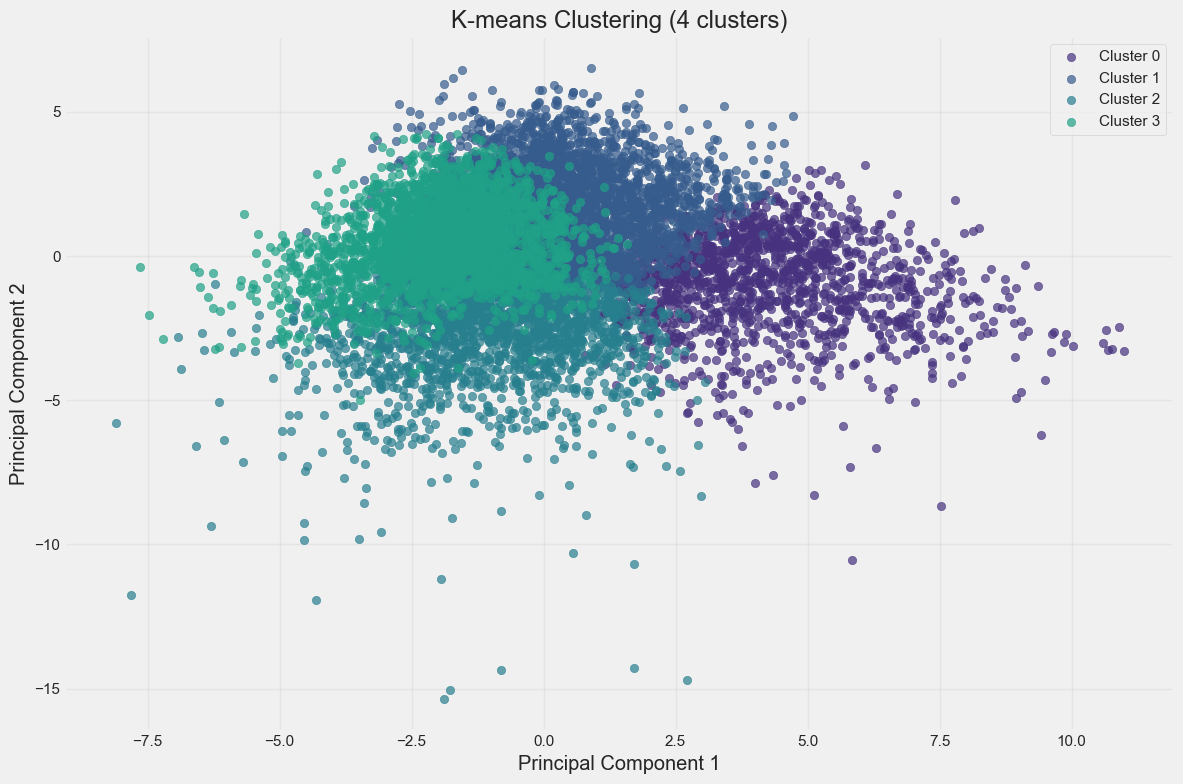


Cluster distribution by player type:


kmeans_cluster,0,1,2,3
player_type,,,,
Activist,244,617,330,565
Pragmatist,62,298,106,204
Reflector,180,312,178,263
Theorist,327,595,357,535


Chi-square test: chi2 = 63.1829, p-value = 0.0000


<Figure size 1200x800 with 0 Axes>

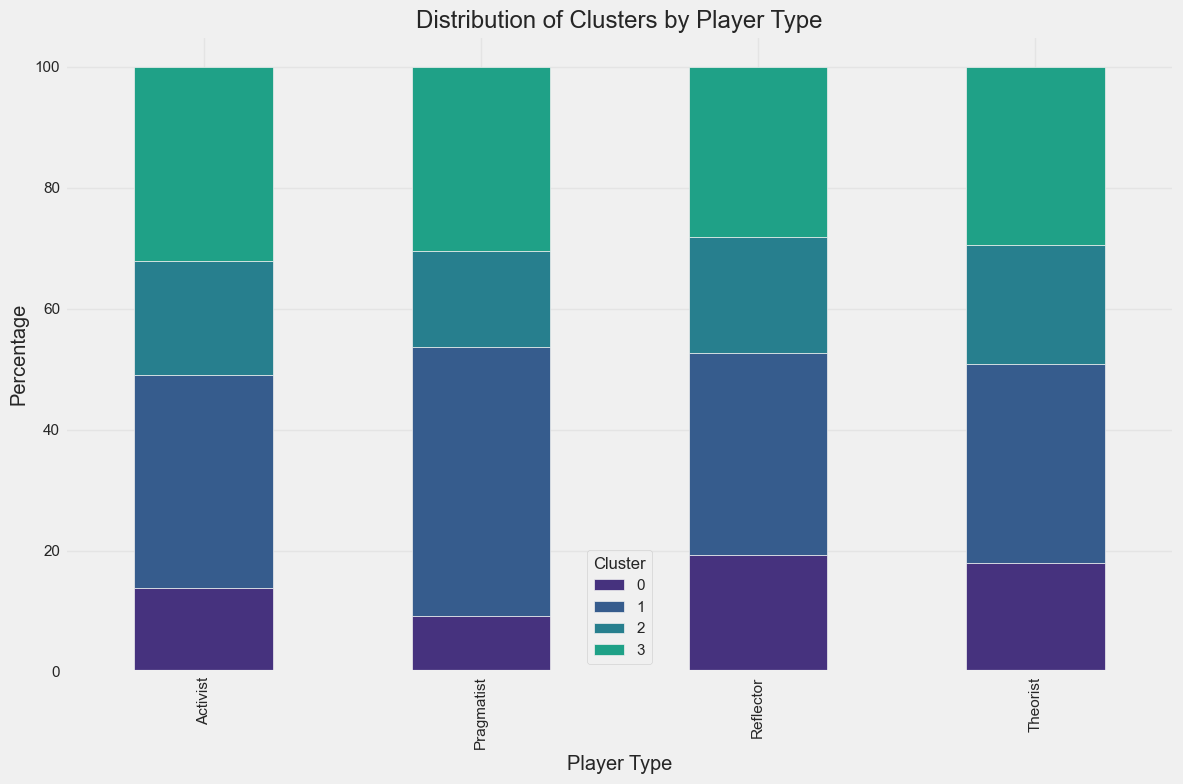

Cluster purity: 0.3607


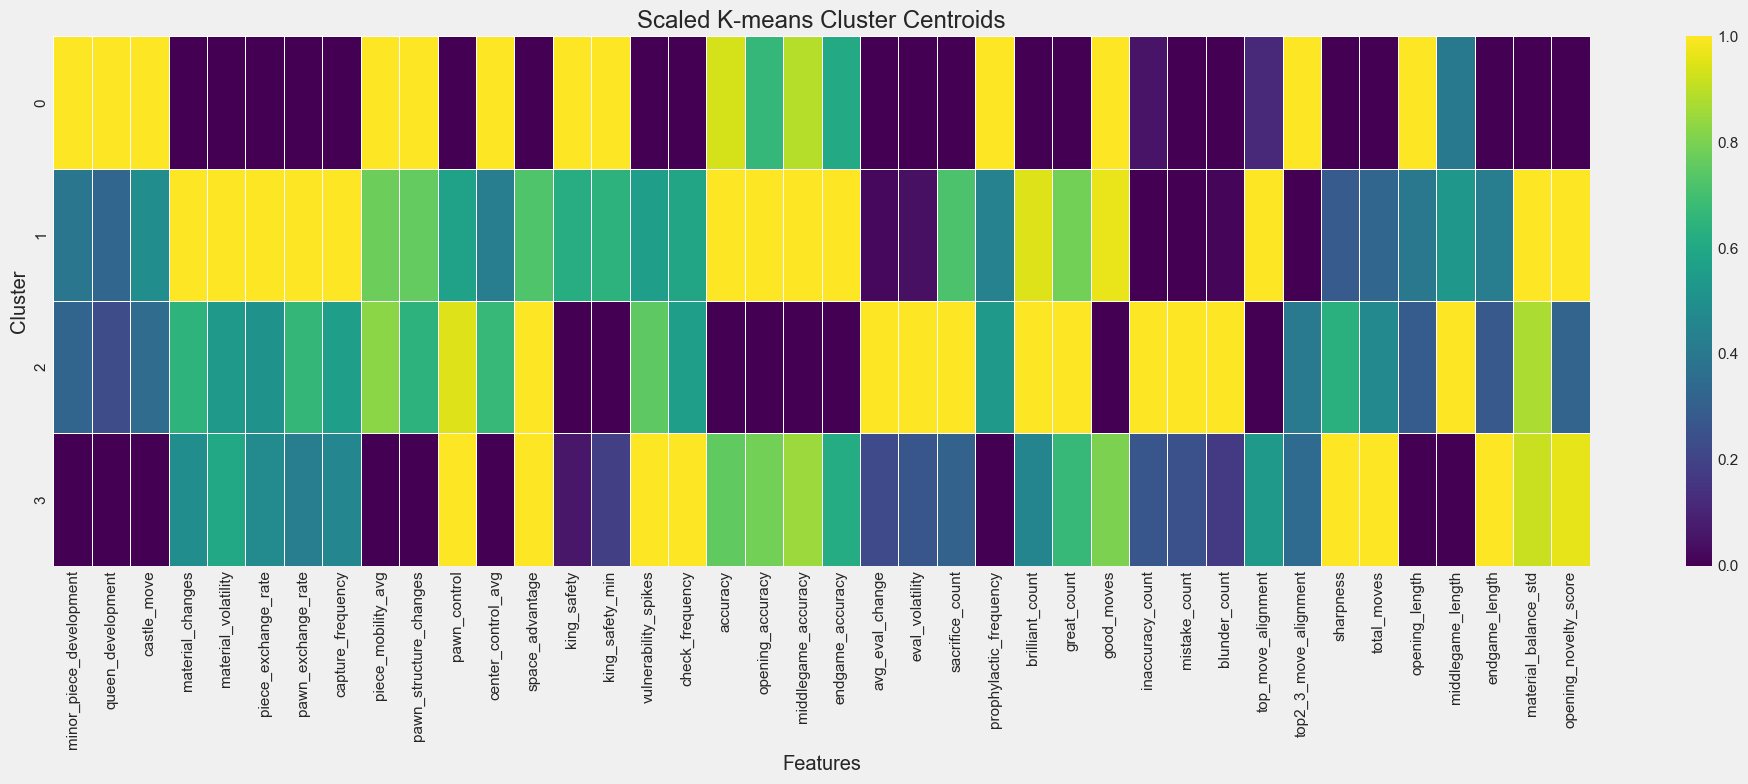


Analyzing player type characteristics...


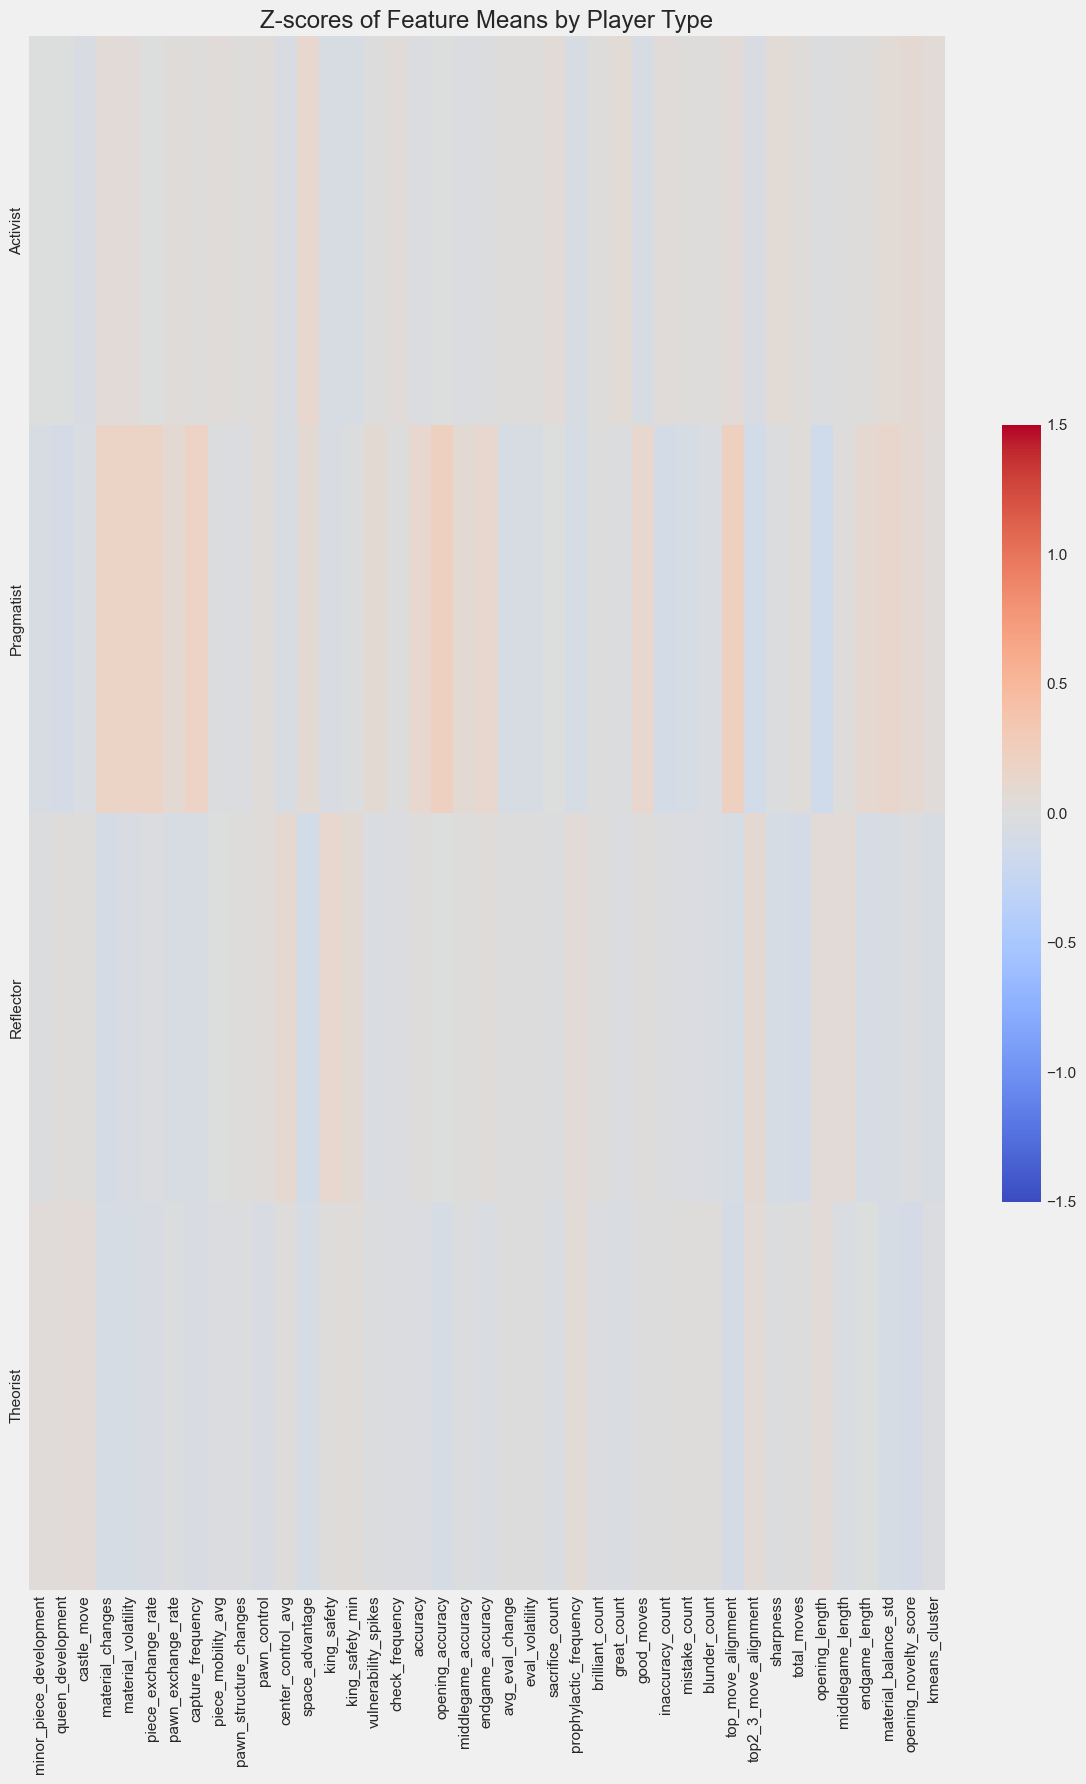


Top distinguishing features for each player type:

Activist:
  space_advantage: 0.12 (higher than average)
  opening_novelty_score: 0.09 (higher than average)
  sharpness: 0.07 (higher than average)
  prophylactic_frequency: -0.07 (lower than average)
  king_safety_min: -0.07 (lower than average)

Pragmatist:
  opening_accuracy: 0.23 (higher than average)
  top_move_alignment: 0.23 (higher than average)
  capture_frequency: 0.19 (higher than average)
  piece_exchange_rate: 0.19 (higher than average)
  material_volatility: 0.18 (higher than average)

Reflector:
  space_advantage: -0.13 (lower than average)
  king_safety: 0.12 (higher than average)
  center_control_avg: 0.10 (higher than average)
  total_moves: -0.09 (lower than average)
  material_changes: -0.09 (lower than average)

Theorist:
  opening_novelty_score: -0.10 (lower than average)
  top_move_alignment: -0.09 (lower than average)
  material_volatility: -0.08 (lower than average)
  space_advantage: -0.08 (lower than average

,Feature,Z-score Range,Highest Type,Highest Z-score,Lowest Type,Lowest Z-score
31,top_move_alignment,0.318772,Pragmatist,0.226032,Theorist,-0.092741
18,opening_accuracy,0.301028,Pragmatist,0.228128,Theorist,-0.072900
3,material_changes,0.263934,Pragmatist,0.177399,Reflector,-0.086535
4,material_volatility,0.259849,Pragmatist,0.182106,Theorist,-0.077744
7,capture_frequency,0.256795,Pragmatist,0.188433,Reflector,-0.068362
12,space_advantage,0.243209,Activist,0.117788,Reflector,-0.125421
5,piece_exchange_rate,0.234485,Pragmatist,0.185889,Theorist,-0.048596
32,top2_3_move_alignment,0.213432,Reflector,0.086425,Pragmatist,-0.127008
38,material_balance_std,0.205578,Pragmatist,0.130962,Theorist,-0.074616
39,opening_novelty_score,0.201892,Pragmatist,0.099585,Theorist,-0.102307



Analysis complete!


In [18]:
# 4. Clustering Analysis

# 4.1 K-means Clustering
def perform_kmeans_clustering():
    """Perform K-means clustering on the features"""
    # Get numeric features
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Set number of clusters to 4 to match our player types
    n_clusters = 4
    
    # Perform K-means with 4 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(scaled_features)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    # Create DataFrame for visualization
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['kmeans_cluster'] = df['kmeans_cluster']
    pca_df['player_name'] = df['player_name']
    pca_df['player_type'] = df['player_type']
    
    # Plot K-means clusters
    plt.figure(figsize=(12, 8))
    for cluster in range(n_clusters):
        cluster_data = pca_df[pca_df['kmeans_cluster'] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-means Clustering (4 clusters)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # If we have player types, analyze cluster-player type relationship
    if labeled_count > 0:
        # Create contingency table
        contingency = pd.crosstab(
            df[df['player_type'].notna()]['player_type'],
            df[df['player_type'].notna()]['kmeans_cluster']
        )
        
        print("\nCluster distribution by player type:")
        display(contingency)
        
        # Calculate chi-square test
        chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
        print(f"Chi-square test: chi2 = {chi2:.4f}, p-value = {p_val:.4f}")
        
        # Visualize cluster-player type relationship
        plt.figure(figsize=(12, 8))
        contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
        contingency_pct.plot(kind='bar', stacked=True)
        plt.xlabel('Player Type')
        plt.ylabel('Percentage')
        plt.title('Distribution of Clusters by Player Type')
        plt.legend(title='Cluster')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Calculate cluster purity
        total = contingency.sum().sum()
        purity = sum(contingency.max(axis=0)) / total
        print(f"Cluster purity: {purity:.4f}")
    
    # Analyze cluster centroids
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_features)
    
    # Scale the centroids for better visualization
    min_max_scaler = MinMaxScaler()
    scaled_centroids = min_max_scaler.fit_transform(cluster_centers)
    scaled_centroids_df = pd.DataFrame(scaled_centroids, columns=numeric_features)
    
    # Plot heatmap of cluster centroids
    plt.figure(figsize=(20, 8))
    sns.heatmap(scaled_centroids_df, cmap='viridis', annot=False, linewidths=.5)
    plt.title('Scaled K-means Cluster Centroids')
    plt.ylabel('Cluster')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Plot radar charts for cluster profiles - fixed to use separate figures for each cluster
    for i in range(n_clusters):
        # Select a subset of important features for readability
        if len(numeric_features) > 15:
            # Use features with highest variance in centroids
            feature_variance = cluster_centers.var().sort_values(ascending=False)
            radar_features = feature_variance.index[:15].tolist()
        else:
            radar_features = numeric_features
            
        # Create radar chart values
        values = scaled_centroids_df.iloc[i][radar_features].tolist()
        # Close the loop for radar chart
        values.append(values[0])
        
        # Create radar chart feature names
        categories = radar_features + [radar_features[0]]
        
        # Create a separate figure for each cluster
        fig = go.Figure()
        
        fig.add_trace(
            go.Scatterpolar(
                r=values,
                theta=categories,
                fill='toself',
                name=f'Cluster {i}'
            )
        )
        
        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 1]
                )
            ),
            showlegend=False,
            height=500,
            width=600,
            title_text=f"Cluster {i} Profile (Normalized Feature Values)"
        )
        
        fig.show()
    
    return kmeans, n_clusters

# 5. Player Type Characteristic Analysis

def analyze_player_type_characteristics():
    """Analyze the distinguishing characteristics of each player type"""
    if labeled_count > 0:
        # Create a dataframe with only labeled data
        labeled_df = df[df['player_type'].notna()].copy()
        
        # Get numeric features
        numeric_features = get_numeric_features()
        
        # Get clean data with imputed values for labeled players only
        clean_data = get_clean_data(df_input=labeled_df, features=numeric_features)
        
        # Join player_type back
        clean_data['player_type'] = labeled_df['player_type']
        
        # Calculate mean values for each feature by player type
        player_type_means = clean_data.groupby('player_type')[numeric_features].mean()
        
        # Calculate Z-scores for each player type relative to overall mean
        overall_means = clean_data[numeric_features].mean()
        overall_stds = clean_data[numeric_features].std()
        
        z_scores = pd.DataFrame()
        for player_type in player_type_means.index:
            z_scores[player_type] = (player_type_means.loc[player_type] - overall_means) / overall_stds
        
        # Plot heatmap of Z-scores
        plt.figure(figsize=(12, 18))
        sns.heatmap(z_scores.T, cmap='coolwarm', center=0, annot=False, 
                   cbar_kws={"shrink": .5}, vmin=-1.5, vmax=1.5)
        plt.title('Z-scores of Feature Means by Player Type')
        plt.tight_layout()
        plt.show()
        
        # For each player type, show top 5 distinguishing features (highest absolute Z-scores)
        print("\nTop distinguishing features for each player type:")
        for player_type in z_scores.columns:
            top_features = z_scores[player_type].abs().sort_values(ascending=False).head(5)
            print(f"\n{player_type}:")
            for feature in top_features.index:
                score = z_scores.loc[feature, player_type]
                direction = "higher" if score > 0 else "lower"
                print(f"  {feature}: {score:.2f} ({direction} than average)")
        
        # Create feature importance table
        importance_data = []
        for feature in z_scores.index:
            # Calculate the range of z-scores for this feature
            z_range = z_scores.loc[feature].max() - z_scores.loc[feature].min()
            # Get player type with max and min value
            max_type = z_scores.loc[feature].idxmax()
            min_type = z_scores.loc[feature].idxmin()
            
            importance_data.append({
                'Feature': feature,
                'Z-score Range': z_range,
                'Highest Type': max_type,
                'Highest Z-score': z_scores.loc[feature, max_type],
                'Lowest Type': min_type,
                'Lowest Z-score': z_scores.loc[feature, min_type]
            })
        
        # Create DataFrame and sort by Z-score range
        importance_df = pd.DataFrame(importance_data)
        importance_df = importance_df.sort_values('Z-score Range', ascending=False)
        
        print("\nFeatures ranked by differentiation power:")
        display(importance_df.head(15))
        
        # Create a radar chart to visualize player type profiles
        # Select the top 10 differentiating features
        top_features = importance_df.head(10)['Feature'].tolist()
        
        # Create a separate radar chart for each player type
        for player_type in z_scores.columns:
            # Prepare data for radar chart
            fig = go.Figure()
            
            values = z_scores.loc[top_features, player_type].tolist()
            # Close the loop for radar chart
            values.append(values[0])
            
            # Create radar chart feature names
            categories = top_features + [top_features[0]]
            
            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=categories,
                fill='toself',
                name=player_type
            ))
            
            fig.update_layout(
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                        range=[-1.5, 1.5]
                    )
                ),
                title=f"{player_type} Profile (Z-scores on Key Features)",
                height=700,
                width=700
            )
            
            fig.show()
        
        # Create a combined radar chart with all player types
        # Use a regular figure instead of subplots
        fig = go.Figure()
        
        for player_type in z_scores.columns:
            values = z_scores.loc[top_features, player_type].tolist()
            # Close the loop for radar chart
            values.append(values[0])
            
            # Create radar chart feature names
            categories = top_features + [top_features[0]]
            
            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=categories,
                fill='toself',
                name=player_type
            ))
        
        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[-1.5, 1.5]
                )
            ),
            title="Player Type Profiles (Z-scores on Key Features)",
            height=700,
            width=900
        )
        
        fig.show()




# Clustering analysis
print("\nPerforming K-means clustering...")
kmeans, optimal_clusters = perform_kmeans_clustering()

if labeled_count > 0:
    print("\nAnalyzing player type characteristics...")
    analyze_player_type_characteristics()

print("\nAnalysis complete!")

Loaded 9310 games with 47 features
Found 135 games for Carlsen
Found 108 games for Caruana
Analyzing 40 features

Most significant differences:
eval_volatility: * (p=0.0152, small effect)
  Carlsen: 154.54, Caruana: 54.85
  Carlsen is higher by 181.7%

avg_eval_change: * (p=0.0267, small effect)
  Carlsen: 37.73, Caruana: 19.73
  Carlsen is higher by 91.2%

check_frequency: * (p=0.0443, small effect)
  Carlsen: 0.06, Caruana: 0.04
  Carlsen is higher by 34.6%



<Figure size 1200x800 with 0 Axes>

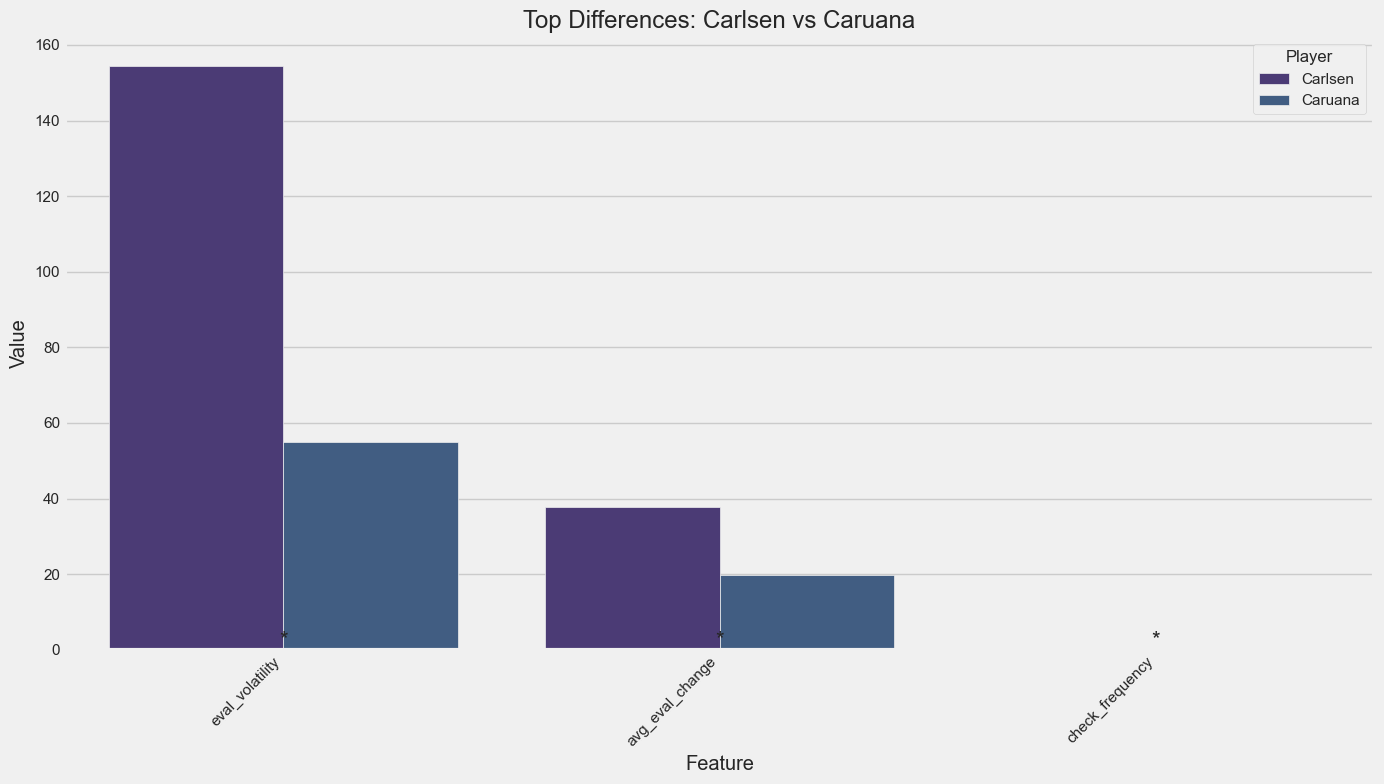


Feature contributions to principal components:

Top features contributing to PC1 (14.28% variance):
  endgame_length: +0.290
  good_moves: +0.272
  accuracy: +0.253
  middlegame_length: -0.246
  inaccuracy_count: -0.243
  middlegame_accuracy: +0.240
  material_volatility: +0.230
  piece_mobility_avg: -0.224
  piece_exchange_rate: +0.222
  capture_frequency: +0.209

Top features contributing to PC2 (13.46% variance):
  total_moves: +0.286
  king_safety: -0.249
  opening_length: -0.247
  material_balance_std: +0.241
  king_safety_min: -0.230
  endgame_length: +0.224
  endgame_accuracy: -0.215
  accuracy: -0.214
  good_moves: -0.199
  vulnerability_spikes: +0.188


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from typing import List, Dict, Optional, Union, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set the style for visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def load_chess_data(csv_file):
    """Load chess data from CSV file and perform basic preprocessing"""
    df = pd.read_csv(csv_file)
    print(f"Loaded {df.shape[0]} games with {df.shape[1]} features")
    
    # Define player types if 'player_type' column exists
    if 'player_type' in df.columns:
        # Map player names to types
        player_types = {
            'Activist': ['Alekhine', 'Tal', 'Spassky', 'Kasparov', 'Anand', 'Shirov'],
            'Theorist': ['Steinitz', 'Botvinnik', 'Kramnik', 'Tarrasch', 'Nimzowitsch', 'Leko', 'Giri'],
            'Reflector': ['Capablanca', 'Smyslov', 'Petrosian', 'Karpov', 'Carlsen', 'Adams'],
            'Pragmatist': ['Fischer', 'Euwe', 'Korchnoi', 'Caruana', 'Ding']
        }
        
        # Fill in missing player types based on player name
        for player_type, names in player_types.items():
            for name in names:
                mask = df['player_name'].str.contains(name, case=False, na=False)
                if any(mask):
                    df.loc[mask & df['player_type'].isna(), 'player_type'] = player_type
    
    # Define feature groups based on available columns
    feature_groups = get_feature_groups(df.columns)
    
    return df, feature_groups

def get_feature_groups(available_columns):
    """Define feature groups based on available columns"""
    # Convert available columns to a list if it's not already
    available_features = list(available_columns)
    
    # Define feature groups with only available features
    feature_groups = {
        'Opening Features': [f for f in [
            'minor_piece_development', 'queen_development', 'castle_move', 
            'opening_novelty_score', 'opening_accuracy', 'opening_length'
        ] if f in available_features],
        
        'Material Handling': [f for f in [
            'material_changes', 'material_volatility', 'piece_exchange_rate', 
            'pawn_exchange_rate', 'capture_frequency', 'material_balance_std'
        ] if f in available_features],
        
        'Positional Features': [f for f in [
            'piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 
            'center_control_avg', 'space_advantage'
        ] if f in available_features],
        
        'King Safety': [f for f in [
            'king_safety', 'king_safety_min', 'vulnerability_spikes', 'check_frequency'
        ] if f in available_features],
        
        'Move Quality': [f for f in [
            'accuracy', 'brilliant_count', 'great_count', 'good_moves', 
            'inaccuracy_count', 'mistake_count', 'blunder_count', 
            'top_move_alignment', 'top2_3_move_alignment'
        ] if f in available_features],
        
        'Game Phase': [f for f in [
            'middlegame_accuracy', 'endgame_accuracy', 'middlegame_length', 'endgame_length'
        ] if f in available_features],
        
        'Strategic Indicators': [f for f in [
            'sacrifice_count', 'prophylactic_frequency', 'sharpness', 
            'eval_volatility', 'avg_eval_change'
        ] if f in available_features],
        
        'Game Stats': [f for f in [
            'total_moves', 'opening_length', 'middlegame_length', 'endgame_length'
        ] if f in available_features]
    }
    
    # Remove empty groups
    feature_groups = {k: v for k, v in feature_groups.items() if v}
    
    return feature_groups

def get_selected_features(df, feature_selection):
    """Get selected features based on different input types"""
    # Define common feature groups
    feature_groups = get_feature_groups(df.columns)
    
    # Identify non-feature columns
    meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                'player_type', 'game_id', 'result']
    
    # If feature_selection is a string, it might be a group name or a keyword
    if isinstance(feature_selection, str):
        if feature_selection in feature_groups:
            # It's a feature group name
            selected_features = feature_groups[feature_selection]
        else:
            # It's a keyword to search in feature names
            selected_features = [col for col in df.columns 
                               if col not in meta_cols 
                               and feature_selection.lower() in col.lower()]
    
    # If it's a list, use those features directly
    elif isinstance(feature_selection, list):
        selected_features = [f for f in feature_selection if f in df.columns]
    
    # If it's a list of group names, combine all groups
    elif isinstance(feature_selection, list) and all(g in feature_groups for g in feature_selection):
        selected_features = []
        for group in feature_selection:
            selected_features.extend(feature_groups[group])
    
    # Default to all numeric features if no selection or invalid selection
    else:
        selected_features = [col for col in df.columns 
                           if col not in meta_cols 
                           and pd.api.types.is_numeric_dtype(df[col])]
    
    return selected_features

def compare_player_games(df, player1, player2, feature_selection=None, top_n=10):
    """
    Compare games between two chess players across multiple features.
    
    Args:
        df: DataFrame with player data
        player1: Name of first player (partial name matching)
        player2: Name of second player (partial name matching)
        feature_selection: Features to analyze (string group name, list of features, or keyword)
        top_n: Number of top differences to display
        
    Returns:
        DataFrame with comparison results
    """
    # Select players' games
    player1_mask = df['player_name'].str.contains(player1, case=False, na=False)
    player2_mask = df['player_name'].str.contains(player2, case=False, na=False)
    
    player1_games = df[player1_mask].copy()
    player2_games = df[player2_mask].copy()
    
    print(f"Found {len(player1_games)} games for {player1}")
    print(f"Found {len(player2_games)} games for {player2}")
    
    if len(player1_games) < 5 or len(player2_games) < 5:
        print("Warning: Very few games found. Results may not be statistically reliable.")
    
    # Get selected features
    selected_features = get_selected_features(df, feature_selection)
    print(f"Analyzing {len(selected_features)} features")
    
    # Add a group column for easier comparison
    player1_games['player_group'] = f"Player: {player1}"
    player2_games['player_group'] = f"Player: {player2}"
    
    # Combine into one dataframe for analysis
    comparison_df = pd.concat([player1_games, player2_games])
    
    # Calculate statistics and significance for each feature
    results = []
    
    for feature in selected_features:
        # Skip if feature doesn't exist
        if feature not in df.columns:
            continue
            
        # Get data for both players
        data1 = player1_games[feature].dropna()
        data2 = player2_games[feature].dropna()
        
        # Skip if not enough data
        if len(data1) < 5 or len(data2) < 5:
            continue
            
        # Calculate statistics
        mean1 = data1.mean()
        mean2 = data2.mean()
        std1 = data1.std()
        std2 = data2.std()
        
        # T-test for significance
        t_stat, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=False)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) / 
                           (len(data1) + len(data2) - 2))
        
        effect_size = abs(mean1 - mean2) / pooled_std if pooled_std > 0 else 0
        
        # Determine which player has higher value
        higher = player1 if mean1 > mean2 else player2
        
        # Calculate percent difference
        pct_diff = ((mean1 - mean2) / abs(mean2)) * 100 if mean2 != 0 else 0
        
        # Add to results
        results.append({
            'Feature': feature,
            'p_value': p_value,
            'effect_size': effect_size,
            player1: mean1,
            player2: mean2,
            'Percent_Diff': pct_diff,
            'Higher': higher
        })
    
    # Create results dataframe and sort by significance
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("No valid features found for comparison.")
        return pd.DataFrame()
        
    results_df = results_df.sort_values('p_value')
    
    # Print top significant differences
    significant_results = results_df[results_df['p_value'] < 0.05]
    
    if len(significant_results) > 0:
        print("\nMost significant differences:")
        for _, row in significant_results.head(top_n).iterrows():
            stars = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            effect = "large" if row['effect_size'] >= 0.8 else "medium" if row['effect_size'] >= 0.5 else "small"
            
            print(f"{row['Feature']}: {stars} (p={row['p_value']:.4f}, {effect} effect)")
            print(f"  {player1}: {row[player1]:.2f}, {player2}: {row[player2]:.2f}")
            print(f"  {row['Higher']} is higher by {abs(row['Percent_Diff']):.1f}%\n")
    else:
        print("No statistically significant differences found.")
        
    # Create visualizations only if we have significant results
    if len(significant_results) > 0:
        # 1. Bar chart of top differences
        plt.figure(figsize=(12, 8))
        
        top_features = significant_results['Feature'].head(min(8, len(significant_results))).tolist()
        
        if top_features:
            # Prepare data for plotting
            plot_data = []
            for feature in top_features:
                row = results_df[results_df['Feature'] == feature].iloc[0]
                plot_data.append({
                    'Feature': feature,
                    player1: row[player1],
                    player2: row[player2],
                    'p_value': row['p_value']
                })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Convert to long format for seaborn
            plot_long = pd.melt(plot_df, 
                               id_vars=['Feature', 'p_value'], 
                               value_vars=[player1, player2],
                               var_name='Player', value_name='Value')
            
            # Create plot
            plt.figure(figsize=(14, 8))
            ax = sns.barplot(x='Feature', y='Value', hue='Player', data=plot_long)
            
            # Add significance stars
            for i, feature in enumerate(top_features):
                p_val = plot_df[plot_df['Feature'] == feature]['p_value'].iloc[0]
                stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
                plt.text(i, 0, stars, ha='center', va='bottom', fontsize=16)
                
            plt.xticks(rotation=45, ha='right')
            plt.title(f'Top Differences: {player1} vs {player2}')
            plt.tight_layout()
            plt.show()
        
            # 2. Radar chart
            # Get top 6 differentiating features
            radar_features = significant_results['Feature'].head(min(6, len(significant_results))).tolist()
            
            try:
                # Create radar chart for features
                fig = go.Figure()
                
                # Prepare normalized values for each player
                values1 = []
                values2 = []
                
                for feature in radar_features:
                    row = results_df[results_df['Feature'] == feature].iloc[0]
                    # Get the raw values
                    val1 = row[player1]
                    val2 = row[player2]
                    
                    # Simple normalization between 0 and 1
                    max_val = max(val1, val2)
                    min_val = min(val1, val2)
                    
                    # Prevent division by zero
                    if max_val == min_val:
                        norm1 = 0.5
                        norm2 = 0.5
                    else:
                        norm1 = (val1 - min_val) / (max_val - min_val)
                        norm2 = (val2 - min_val) / (max_val - min_val)
                    
                    values1.append(norm1)
                    values2.append(norm2)
                    
                # Close the loop for the radar chart
                values1.append(values1[0])
                values2.append(values2[0])
                radar_features_closed = radar_features + [radar_features[0]]
                
                # Add traces
                fig.add_trace(go.Scatterpolar(
                    r=values1,
                    theta=radar_features_closed,
                    fill='toself',
                    name=player1
                ))
                
                fig.add_trace(go.Scatterpolar(
                    r=values2,
                    theta=radar_features_closed,
                    fill='toself',
                    name=player2
                ))
                
                fig.update_layout(
                    polar=dict(
                        radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                    ),
                    title=f"Playing Style Comparison: {player1} vs {player2}",
                    width=700,
                    height=700
                )
                
                fig.show()
            except Exception as e:
                print(f"Error creating radar chart: {e}")
                print("Skipping radar chart visualization.")
    
    # 3. Visualize the players in PCA space
    visualize_players_pca(comparison_df, player1, player2, selected_features)
    
    return results_df

def visualize_players_pca(df, player1=None, player2=None, features=None, n_components=2, 
                         color_by='player_group', interactive=True):
    """
    Visualize players in a reduced dimensional space using PCA
    
    Args:
        df: DataFrame with player data
        player1: Name of first player (optional)
        player2: Name of second player (optional)
        features: Features to use for PCA (if None, will use all numeric features)
        n_components: Number of PCA components to use
        color_by: Column to use for coloring points
        interactive: Whether to use plotly for interactive visualization
    """
    # If we don't have the color column, default to player_name
    if color_by not in df.columns and 'player_name' in df.columns:
        color_by = 'player_name'
    
    # If we don't have a player_name, just do PCA without player labels
    if 'player_name' not in df.columns:
        player1 = None
        player2 = None
    
    # Filter data if player names are provided
    if player1 or player2:
        if player1:
            mask1 = df['player_name'].str.contains(player1, case=False, na=False)
        else:
            mask1 = pd.Series([False] * len(df))
            
        if player2:
            mask2 = df['player_name'].str.contains(player2, case=False, na=False)
        else:
            mask2 = pd.Series([False] * len(df))
            
        # Combine masks
        selected_df = df[mask1 | mask2].copy()
        
        if len(selected_df) == 0:
            print("No matching games found for the specified players.")
            return
    else:
        selected_df = df.copy()
    
    # Get features for PCA
    if features is None:
        # Exclude non-numeric and metadata columns
        meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result', 'player_group']
        features = [col for col in selected_df.columns 
                  if col not in meta_cols and pd.api.types.is_numeric_dtype(selected_df[col])]
    
    # Ensure features exist in the dataframe
    features = [f for f in features if f in selected_df.columns]
    
    if len(features) < 2:
        print("Need at least 2 features for PCA.")
        return
    
    # Handle missing values
    feature_data = selected_df[features].copy()
    has_missing = feature_data.isna().any().any()
    
    if has_missing:
        imputer = SimpleImputer(strategy='median')
        feature_data = pd.DataFrame(
            imputer.fit_transform(feature_data),
            columns=features
        )
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(feature_data)
    
    # Perform PCA
    pca = PCA(n_components=min(n_components, len(features)))
    pca_result = pca.fit_transform(scaled_data)
    
    # Create a DataFrame with the PCA results
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
    )
    
    # Add metadata for visualization
    if color_by in selected_df.columns:
        pca_df[color_by] = selected_df[color_by].values
    
    if 'player_name' in selected_df.columns:
        pca_df['player_name'] = selected_df['player_name'].values
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    
    # Create visualization
    if interactive and len(pca_df) > 0:
        try:
            # Use plotly for interactive plot
            hover_data = ['player_name'] if 'player_name' in pca_df.columns else None
            
            fig = px.scatter(
                pca_df, 
                x='PC1', 
                y='PC2',
                color=color_by if color_by in pca_df.columns else None,
                hover_name='player_name' if 'player_name' in pca_df.columns else None,
                hover_data=hover_data,
                title=f'PCA of Chess Games (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})'
            )
            
            # Update layout
            fig.update_layout(
                xaxis_title=f'PC1 ({explained_variance[0]:.2%} variance)',
                yaxis_title=f'PC2 ({explained_variance[1]:.2%} variance)',
                width=1000,
                height=700
            )
            
            # Show plot
            fig.show()
            
        except Exception as e:
            print(f"Error creating interactive plot: {e}")
            print("Falling back to static plot.")
            interactive = False
            
    if not interactive and len(pca_df) > 0:
        # Use matplotlib for static plot
        plt.figure(figsize=(12, 8))
        
        # If we have a coloring column, use it
        if color_by in pca_df.columns:
            # Get unique values
            color_values = pca_df[color_by].unique()
            
            # Create scatter plot for each value
            for value in color_values:
                subset = pca_df[pca_df[color_by] == value]
                plt.scatter(
                    subset['PC1'],
                    subset['PC2'],
                    label=value,
                    alpha=0.7,
                    s=70
                )
                
                # If we have player names, annotate some points
                if 'player_name' in subset.columns:
                    # Annotate a few points
                    for _, row in subset.head(3).iterrows():
                        name = row['player_name']
                        if isinstance(name, str) and ',' in name:
                            name = name.split(',')[0]  # Use just the last name
                        plt.annotate(
                            name,
                            (row['PC1'], row['PC2']),
                            fontsize=9,
                            alpha=0.8
                        )
            
            plt.legend()
        else:
            # Simple scatter plot without coloring
            plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
        
        plt.title(f'PCA of Chess Games (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})')
        plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Print feature contributions to PC1 and PC2
    print("\nFeature contributions to principal components:")
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
        index=features
    )
    
    # Display top 10 contributing features for each component
    for pc in range(min(2, pca.components_.shape[0])):
        pc_name = f'PC{pc+1}'
        contributions = components_df[pc_name].abs().sort_values(ascending=False)
        
        print(f"\nTop features contributing to {pc_name} ({explained_variance[pc]:.2%} variance):")
        for feature, value in contributions.head(10).items():
            sign = '+' if components_df.loc[feature, pc_name] > 0 else '-'
            print(f"  {feature}: {sign}{value:.3f}")
    
    return pca, pca_df

def analyze_single_player(df, player_name, feature_combinations=None, n_clusters=3):
    """
    Analyze games of a single player to identify patterns and clusters
    """
    # Select player's games
    player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
    player_games = df[player_mask].copy()
    
    # Reset index to avoid non-consecutive index issues
    player_games = player_games.reset_index(drop=True)
    
    print(f"Found {len(player_games)} games for {player_name}")
    
    if len(player_games) < 10:
        print("Warning: Very few games found. Analysis may not be reliable.")
        return
    
    # Define feature combinations to try if not provided
    if feature_combinations is None:
        # Create interesting combinations of feature groups
        feature_groups = get_feature_groups(df.columns)
        
        feature_combinations = [
            ['Move Quality'],  # How the player performs in terms of move quality
            ['Opening Features', 'Game Phase'],  # Opening preferences and phase transitions
            ['Material Handling', 'Positional Features'],  # Material vs position handling
            ['Strategic Indicators', 'King Safety'],  # Strategic choices and safety
            ['all']  # All features combined
        ]
        
        # Convert to actual features
        feature_combinations = [
            get_selected_features(df, combo) if combo != ['all'] else get_selected_features(df, None)
            for combo in feature_combinations
        ]
    
    # Analyze each feature combination
    for i, features in enumerate(feature_combinations):
        print(f"\n--- Feature Combination {i+1}: {len(features)} features ---")
        
        # Skip if too few features
        if len(features) < 2:
            print("Skipping: Need at least 2 features for analysis")
            continue
        
        # Get feature data
        feature_data = player_games[features].copy()
        
        # Handle missing values
        has_missing = feature_data.isna().any().any()
        if has_missing:
            imputer = SimpleImputer(strategy='median')
            feature_data = pd.DataFrame(
                imputer.fit_transform(feature_data),
                columns=features
            )
        
        # Calculate basic statistics
        print("\nKey statistics:")
        for feature in features[:5]:  # Show stats for first 5 features
            mean = feature_data[feature].mean()
            std = feature_data[feature].std()
            min_val = feature_data[feature].min()
            max_val = feature_data[feature].max()
            print(f"  {feature}: mean={mean:.2f}, std={std:.2f}, range=[{min_val:.2f}, {max_val:.2f}]")
        
        if len(features) > 5:
            print(f"  ... and {len(features) - 5} more features")
        
        # Visualize in PCA space
        try:
            # Perform clustering to identify patterns
            if len(feature_data) >= n_clusters * 3:  # Need enough data for clustering
                # Scale data
                scaler = StandardScaler()
                scaled_data = scaler.fit_transform(feature_data)
                
                # Perform KMeans clustering
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(scaled_data)
                
                # Add cluster information
                player_games[f'cluster_{i+1}'] = clusters
                
                # Visualize clusters
                print(f"\nIdentified {n_clusters} distinct playing patterns:")
                
                # Calculate cluster statistics
                for cluster_id in range(n_clusters):
                    cluster_size = np.sum(clusters == cluster_id)
                    print(f"  Pattern {cluster_id+1}: {cluster_size} games ({cluster_size/len(clusters)*100:.1f}%)")
                
                # Calculate feature importance for each cluster
                cluster_centers = pd.DataFrame(
                    kmeans.cluster_centers_,
                    columns=features
                )
                
                # Scale centers for better comparison
                min_max = MinMaxScaler()
                scaled_centers = pd.DataFrame(
                    min_max.fit_transform(cluster_centers),
                    columns=features
                )
                
                # Identify top features for each cluster
                for cluster_id in range(n_clusters):
                    # Find features where this cluster ranks highest
                    top_features = []
                    for feature in features:
                        # Get rank of this cluster for this feature
                        values = scaled_centers[feature].values
                        rank = np.argsort(values)[::-1].tolist().index(cluster_id)
                        
                        if rank == 0:  # This cluster ranks highest
                            top_features.append(feature)
                    
                    if top_features:
                        print(f"  Pattern {cluster_id+1} distinctive traits: {', '.join(top_features[:3])}")
            
            # Create visualization with PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(feature_data)
            
            # Create dataframe for visualization
            pca_df = pd.DataFrame(
                data=pca_result,
                columns=['PC1', 'PC2']
            )
            
            # Add metadata
            if len(player_games) >= n_clusters * 3:
                pca_df['Cluster'] = clusters
            
            if 'result' in player_games.columns:
                pca_df['Result'] = player_games['result'].values
            
            if 'opponent_name' in player_games.columns:
                pca_df['Opponent'] = player_games['opponent_name'].values
            
            # Get explained variance
            explained_variance = pca.explained_variance_ratio_
            
            # Create scatter plot
            plt.figure(figsize=(12, 8))
            
            pattern_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']  # Red, Blue, Green, Purple, Orange
            
            if 'Cluster' in pca_df.columns:
                # Color by cluster
                for cluster_id in range(n_clusters):
                    cluster_data = pca_df[pca_df['Cluster'] == cluster_id]
                    plt.scatter(
                        cluster_data['PC1'],
                        cluster_data['PC2'],
                        label=f'Pattern {cluster_id+1}',
                        color=pattern_colors[cluster_id % len(pattern_colors)],
                        alpha=0.7,
                        s=70
                    )
            else:
                # Simple scatter without clustering
                plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
            
            # Add annotations for notable games
            if 'Opponent' in pca_df.columns:
                # Find games against notable opponents or with extreme positions
                notable_indices = []
                
                # Games with extreme PC1 or PC2 values
                extreme_pc1 = pca_df.iloc[np.argsort(np.abs(pca_df['PC1']))[-3:]].index
                extreme_pc2 = pca_df.iloc[np.argsort(np.abs(pca_df['PC2']))[-3:]].index
                notable_indices.extend(extreme_pc1)
                notable_indices.extend(extreme_pc2)
                
                # Deduplicate
                notable_indices = list(set(notable_indices))
                
                # Annotate these games
                for idx in notable_indices:
                    opponent = pca_df.loc[idx, 'Opponent']
                    if isinstance(opponent, str) and ',' in opponent:
                        opponent = opponent.split(',')[0]  # Just last name
                    
                    result = ''
                    if 'Result' in pca_df.columns:
                        result = f" ({pca_df.loc[idx, 'Result']})"
                    
                    plt.annotate(
                        f"{opponent}{result}",
                        (pca_df.loc[idx, 'PC1'], pca_df.loc[idx, 'PC2']),
                        fontsize=9,
                        alpha=0.8
                    )
            
            plt.title(f'{player_name} Playing Patterns (Explained variance: {explained_variance[0]:.2%}, {explained_variance[1]:.2%})')
            plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
            if 'Cluster' in pca_df.columns:
                plt.legend(title="Playing Patterns")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Display feature contributions
            components_df = pd.DataFrame(
                pca.components_.T,
                columns=['PC1', 'PC2'],
                index=features
            )
            
            # Show top contributing features
            pc1_features = components_df['PC1'].abs().sort_values(ascending=False).head(5).index.tolist()
            pc2_features = components_df['PC2'].abs().sort_values(ascending=False).head(5).index.tolist()
            
            print("\nKey dimensions of playing style variation:")
            print(f"  Dimension 1 ({explained_variance[0]:.2%} of variation): {', '.join(pc1_features)}")
            print(f"  Dimension 2 ({explained_variance[1]:.2%} of variation): {', '.join(pc2_features)}")
            
            # Create radar chart for clusters if we have them
            if len(player_games) >= n_clusters * 3:
                # Create radar chart for clusters
                fig = go.Figure()
                
                # Select top features for radar chart
                all_top_features = set(pc1_features + pc2_features)
                radar_features = list(all_top_features)[:min(8, len(all_top_features))]
                
                for cluster_id in range(n_clusters):
                    # Get normalized values for this cluster
                    values = []
                    for feature in radar_features:
                        feature_idx = features.index(feature)
                        # Get raw cluster center value
                        center_value = kmeans.cluster_centers_[cluster_id, feature_idx]
                        # Normalize to 0-1 range across all clusters
                        min_val = np.min(kmeans.cluster_centers_[:, feature_idx])
                        max_val = np.max(kmeans.cluster_centers_[:, feature_idx])
                        if max_val > min_val:
                            norm_value = (center_value - min_val) / (max_val - min_val)
                        else:
                            norm_value = 0.5
                        values.append(norm_value)
                    
                    # Close the loop for radar chart
                    values.append(values[0])
                    radar_features_closed = radar_features + [radar_features[0]]
                    
                    # Add trace for this cluster
                    fig.add_trace(go.Scatterpolar(
                        r=values,
                        theta=radar_features_closed,
                        fill='toself',
                        name=f'Pattern {cluster_id+1}'
                    ))
                
                # Update layout
                fig.update_layout(
                    polar=dict(
                        radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                    ),
                    title=f"{player_name}'s Playing Pattern Profiles",
                    width=700,
                    height=700
                )
                
                fig.show()
        
        except Exception as e:
            print(f"Error in PCA analysis: {e}")
            continue
    
    # Find most distinctive games
    all_features = get_selected_features(df, None)
    feature_data = player_games[all_features].copy()
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    feature_data = pd.DataFrame(
        imputer.fit_transform(feature_data),
        columns=all_features
    )
    
    # Calculate global means and std for all players
    global_mean = df[all_features].mean()
    global_std = df[all_features].std()
    
    # Calculate z-scores for this player's games
    z_scores = (feature_data - global_mean) / global_std
    
    # Calculate distinctiveness score (sum of absolute z-scores)
    distinctiveness = z_scores.abs().sum(axis=1)
    
    # Get top 5 most distinctive games
    top_indices = distinctiveness.sort_values(ascending=False).head(5).index
    
    print("\nMost distinctive games:")
    for i, idx in enumerate(top_indices):
        # Get game info
        opponent = player_games.loc[idx, 'opponent_name'] if 'opponent_name' in player_games.columns else 'Unknown'
        result = player_games.loc[idx, 'result'] if 'result' in player_games.columns else 'Unknown'
        game_id = player_games.loc[idx, 'game_id'] if 'game_id' in player_games.columns else idx
        
        # Get top distinctive features
        game_z_scores = z_scores.loc[idx].abs().sort_values(ascending=False)
        top_features = game_z_scores.head(3).index.tolist()
        
        # Format feature values
        feature_values = []
        for feature in top_features:
            value = player_games.loc[idx, feature]
            z = z_scores.loc[idx, feature]
            direction = "high" if z > 0 else "low"
            feature_values.append(f"{feature}: {value:.2f} ({direction}, z={z:.2f})")
        
        print(f"{i+1}. Game {game_id}: vs {opponent}, Result: {result}")
        print(f"   Distinctive features: {', '.join(feature_values)}")
        print()
    
    return player_games

def test_feature_combinations(df, player1, player2, feature_combinations=None):
    """
    Test different feature combinations to find the most distinctive differences
    between two players
    
    Args:
        df: DataFrame with player data
        player1: Name of first player
        player2: Name of second player
        feature_combinations: List of feature combinations to try
    """
    # Define feature combinations if not provided
    if feature_combinations is None:
        feature_groups = get_feature_groups(df.columns)
        
        # Single groups
        single_groups = list(feature_groups.keys())
        
        # Paired groups
        paired_groups = []
        for i, group1 in enumerate(single_groups):
            for group2 in single_groups[i+1:]:
                paired_groups.append([group1, group2])
        
        # Use first 4 single groups and first 3 paired groups
        feature_combinations = single_groups[:4] + paired_groups[:3]
    
    # Run comparisons for each combination
    results = {}
    
    for combo in feature_combinations:
        print("\n" + "="*80)
        if isinstance(combo, list):
            print(f"Testing combination: {' + '.join(combo)}")
        else:
            print(f"Testing group: {combo}")
        print("="*80)
        
        # Run comparison
        combo_results = compare_player_games(df, player1, player2, combo)
        
        # Store results
        if not combo_results.empty:
            # Count significant differences
            sig_count = sum(combo_results['p_value'] < 0.05)
            
            # Store in results dict
            combo_name = ' + '.join(combo) if isinstance(combo, list) else combo
            results[combo_name] = {
                'significant_count': sig_count,
                'min_p_value': combo_results['p_value'].min() if not combo_results.empty else 1.0,
                'features': len(combo_results)
            }
    
    # Print summary
    print("\n" + "="*80)
    print("FEATURE COMBINATION SUMMARY")
    print("="*80)
    
    # Sort by number of significant features
    sorted_results = sorted(results.items(), key=lambda x: x[1]['significant_count'], reverse=True)
    
    for combo_name, stats in sorted_results:
        print(f"{combo_name}:")
        print(f"  Significant differences: {stats['significant_count']}/{stats['features']} features")
        print(f"  Most significant p-value: {stats['min_p_value']:.6f}")
        print()
    
    return results

# Run a comprehensive analysis for specific players
def run_player_analysis(csv_file, player_name, comparison_players=None):
    """
    Run a comprehensive analysis for a specific player
    
    Args:
        csv_file: Path to the player data CSV
        player_name: Name of the player to analyze
        comparison_players: List of player names to compare against
    """
    # Load data
    df, feature_groups = load_chess_data(csv_file)
    
    print("="*80)
    print(f"COMPREHENSIVE ANALYSIS FOR: {player_name}")
    print("="*80)
    
    # 1. Analyze single player
    print("\n--- INDIVIDUAL PLAYING STYLE ANALYSIS ---")
    player_data = analyze_single_player(df, player_name)
    
    # 2. Compare with other players if specified
    if comparison_players:
        for comparison_player in comparison_players:
            print("\n" + "="*80)
            print(f"COMPARING {player_name} vs {comparison_player}")
            print("="*80)
            
            # Run comparison
            compare_player_games(df, player_name, comparison_player)
    
    # 3. Compare with different player types
    if 'player_type' in df.columns:
        player_types = df['player_type'].dropna().unique()
        
        print("\n" + "="*80)
        print(f"COMPARING {player_name} WITH DIFFERENT PLAYER TYPES")
        print("="*80)
        
        for player_type in player_types:
            # Filter games for this player type (except the target player)
            player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
            type_mask = (df['player_type'] == player_type) & (~player_mask)
            
            type_games = df[type_mask]
            if len(type_games) < 10:
                continue  # Skip if too few games
                
            print(f"\n--- Comparison with {player_type} players ({len(type_games)} games) ---")
            
            # Create a temporary dataframe for comparison
            type_df = pd.concat([df[player_mask], type_games])
            
            # Add comparison group
            type_df['player_group'] = 'Other'
            type_df.loc[player_mask, 'player_group'] = f"Player: {player_name}"
            type_df.loc[type_mask, 'player_group'] = f"Type: {player_type}"
            
            # Run comparison with selected feature groups for clarity
            important_groups = ['Move Quality', 'Strategic Indicators', 'Positional Features']
            selected_features = []
            for group in important_groups:
                if group in feature_groups:
                    selected_features.extend(feature_groups[group])
            
            compare_player_games(type_df, player_name, player_type, selected_features)
    
    # 4. Try different feature combinations
    if comparison_players and len(comparison_players) > 0:
        print("\n" + "="*80)
        print(f"TESTING DIFFERENT FEATURE COMBINATIONS WITH {comparison_players[0]}")
        print("="*80)
        
        test_feature_combinations(df, player_name, comparison_players[0])
    
    print("\nAnalysis complete!")
    
def plot_player_features_and_pca(df, player_name, feature_pairs, pca_features=None):
    """
    Create a visualization with feature pair plots and PCA for a player
    
    Args:
        df: DataFrame with player data
        player_name: Name of the player to analyze
        feature_pairs: List of (x_feature, y_feature) pairs to plot
        pca_features: Features to use for PCA (defaults to all numeric features)
    """
    # Select player's games
    player_mask = df['player_name'].str.contains(player_name, case=False, na=False)
    player_df = df[player_mask].copy().reset_index(drop=True)
    
    print(f"Found {len(player_df)} games for {player_name}")
    
    if len(player_df) < 5:
        print(f"Not enough games found for {player_name}")
        return
    
    # Create figure with subplots
    n_pairs = len(feature_pairs)
    fig, axes = plt.subplots(1, n_pairs + 1, figsize=(15, 5), gridspec_kw={'width_ratios': [1] * n_pairs + [1.2]})
    
    # Plot feature pairs
    for i, (x_feature, y_feature) in enumerate(feature_pairs):
        if x_feature in player_df.columns and y_feature in player_df.columns:
            # Create scatter plot
            axes[i].scatter(
                player_df[x_feature], 
                player_df[y_feature], 
                alpha=0.7, 
                color='#3366cc',
                edgecolor='white',
                s=70
            )
            
            # Add labels
            axes[i].set_xlabel(x_feature, fontsize=10)
            axes[i].set_ylabel(y_feature, fontsize=10)
            axes[i].set_title(f"{x_feature} vs {y_feature}", fontsize=12)
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, "Features not available", 
                        ha='center', va='center', transform=axes[i].transAxes)
    
    # Perform PCA
    if pca_features is None:
        # Use all numeric features
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                       'player_type', 'game_id', 'result']
        pca_features = [col for col in player_df.columns 
                       if col not in exclude_cols and pd.api.types.is_numeric_dtype(player_df[col])]
    
    # Filter to features that exist in the dataframe
    pca_features = [f for f in pca_features if f in player_df.columns]
    
    if len(pca_features) >= 2:
        # Handle missing values
        from sklearn.impute import SimpleImputer
        
        # Get feature data
        feature_data = player_df[pca_features].copy()
        
        if feature_data.isna().any().any():
            imputer = SimpleImputer(strategy='median')
            feature_data = pd.DataFrame(
                imputer.fit_transform(feature_data),
                columns=pca_features
            )
        
        # Standardize data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(feature_data)
        
        # Perform PCA
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        
        # Create PCA plot
        explained_variance = pca.explained_variance_ratio_
        
        axes[-1].scatter(
            pca_result[:, 0],
            pca_result[:, 1],
            alpha=0.7,
            color='#3366cc',
            edgecolor='white',
            s=70
        )
        
        # Add labels
        axes[-1].set_xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=10)
        axes[-1].set_ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=10)
        axes[-1].set_title(f"PCA of {player_name}'s Games", fontsize=12)
        axes[-1].grid(True, alpha=0.3)
        
        # Add a bit more explanation
        fig.suptitle(f"Feature Analysis for {player_name}", fontsize=14, y=1.05)
    else:
        axes[-1].text(0.5, 0.5, "Not enough features for PCA", 
                     ha='center', va='center', transform=axes[-1].transAxes)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print feature contributions to PCA
    if len(pca_features) >= 2:
        print("\nFeature contributions to PCA:")
        for i in range(2):
            contributions = pd.Series(
                pca.components_[i], 
                index=pca_features
            ).abs().sort_values(ascending=False)
            
            print(f"\nPC{i+1} ({explained_variance[i]:.2%} variance) top features:")
            for feature, value in contributions.head(5).items():
                print(f"  {feature}: {value:.3f}")

# Example usage
if __name__ == "__main__":
    # Load the data
    df, _ = load_chess_data('player_centric_data.csv')
    
    # Example 1: Compare Tal vs Kramnik
    compare_player_games(df, 'Carlsen', 'Caruana')
    
    # Example 2: Analyze Tal's games
    # analyze_single_player(df, 'Tal')
    
    # # Define pairs of features to plot
    # feature_pairs = [
    #     ('sacrifice_count', 'accuracy'),
    #     ('sharpness', 'king_safety'),
    #     ('blunder_count', 'brilliant_count')
    # ]

    # # Run the visualization
    # plot_player_features_and_pca(df, 'Tal', feature_pairs)
    
    # Example 3: Visualize multiple players in PCA space
    # visualize_players_pca(df, features=['sacrifice_count', 'sharpness', 'king_safety'])
    
    # Example 4: Comprehensive analysis
    # run_player_analysis('player_centric_data.csv', 'Tal', ['Kramnik', 'Kasparov'])
    
    # Example 5: Test different feature combinations
    # test_feature_combinations(df, 'Tal', 'Kramnik')